In [1]:
%matplotlib inline
# %matplotlib widget
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ligo.skymap.plot # Used for geo aitoff projection
import csv
import pickle
import intervals as I # Used to do interval union math
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo # Used to calculate comoving dist
from astropy.table import Table, QTable
from astropy.io import fits # To handle FERMI data
from astropy import wcs
from astropy.wcs import WCS
from pytictoc import TicToc # Used to time Code
from multiprocessing import Pool # Used for multicore processing
from collections import Counter # Used to verify fermi data cleansing
from itertools import chain, combinations
from collections import defaultdict # Used to merge dictionaries
from matplotlib.colors import Normalize # To normalize z for plot coloring
# from mpl_toolkits.mplot3d import Axes3D # 3d plotting
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.stats import chi2
import scipy.stats as stats 
from sklearn.metrics import r2_score
from custom_functions import *
# import custom_functions as cf

# '''No longer necessary when using VSCode'''
# CLOCK = TicToc() # Create instance to time code blocks
PI = math.pi

In [2]:
wee = I.closed(0, 0.25)

woo = I.closed(0.75, 1)

waa = I.closed(0.1, 0.3)

lol = [wee, woo, waa]

union = I.closed(0, 0)

for rango in lol:
    union = union | rango

union

[0,0.3] | [0.75,1]

In [3]:
# Moved to custom functions. Deleting on next commit
# def calc_voidiness(union):
#     voidiness = 0
#     for voidichord in union:
#         if ~voidichord.is_empty(): # This protects against empty intervals
#             try:
#                 voidiness += voidichord.upper - voidichord.lower
#             except:
#                 continue # get sidestepped 
#             # Ok but actually, some intervals are atomic and have a neg inf and
#             # pos inf upper bound. This is a deeper problem. 
#             # Some ints, their lower bound is higher than the upper. This needs to
#             # be investigated
#             # TODO: investigate emtpy intervals.
#             # I am back from the future. I checked it.
#             # The empty intervals are actually properly detecting edge cases,
#             # where the source lies just barely in front of the void, but passes
#             # all tests as if it were inside or behind.
#             # They will be kept in the code to detect and discard bad edge cases. 
#     return voidiness

In [4]:
# Read void table data from text file
voids = pd.read_table("void_data.txt", sep=",")  # Void data already parsed
voids.drop(columns=voids.columns[0], axis=1, inplace=True) # Removes redundant row counter column

# Void Data Processing

## Z distribution

In [5]:
# Removing MAO voids from the study
sutter_idx = voids.index[~(voids['label'] == "Mao")]
sut_voids = voids.loc[sutter_idx]
voids = sut_voids.copy() # Force voids to be a true copy rather than a new pointer

Max z: 0.6906
Min z: 0.00394
Range: 0.6866599999999999 


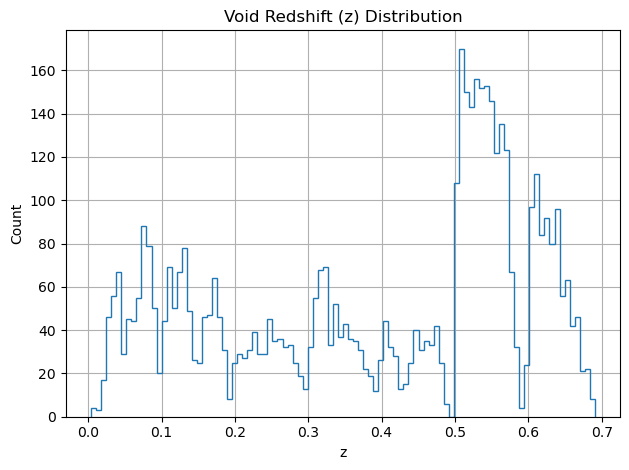

In [6]:
# Plot void z histogram
plt.hist(voids['z'], bins=100, histtype="step") # 100 bins chosen arbitrarily
plt.xlabel('z')
plt.ylabel('Count')
plt.title('Void Redshift (z) Distribution')
plt.grid()
plt.tight_layout()

# z range
max_z = voids['z'].max()
min_z = voids['z'].min()
print(f"Max z: {max_z}\nMin z: {min_z}\nRange: {max_z - min_z} ")

In [7]:
# Calculating comoving distance from z
# NOTE: WMAP9 uses H0 = 69.3 (km/s)/Mpc compared to 69.7 used to calculate h. This should be okay. 7/5/23
void_cmvd = cosmo.comoving_distance(voids['z']) # Comoving distance to void center
voids['cmvd_Mpc'] = void_cmvd.value # add it to data table

# Calculating effective radii in angular seperation units
H = 69.7 * ((u.km/u.s)/u.Mpc) # H0 hubble constant used for this study
h = H/(100 * ((u.km/u.s)/u.Mpc))

void_r = (voids['Reff']) / h.value # [Mpc]
voids['Reff_Mpc'] = void_r

#radius of voids in angular seperation
void_r_angs = np.arctan2(void_r,void_cmvd.value) * (180/math.pi) # Deg
voids['r_ang_deg'] = void_r_angs


In [8]:
voids

,ID,RAdeg,DEdeg,z,Reff,DR,label,cmvd_Mpc,Reff_Mpc,r_ang_deg
1228,10641,173.40,-1.16,0.44680,20.48,9,cmassdim,1735.867077,29.383070,0.969755
1229,28197,207.63,2.39,0.44921,76.93,9,cmassdim,1744.149414,110.373027,3.620955
1230,8812,163.83,-0.78,0.45341,26.77,9,cmassdim,1758.556219,38.407461,1.251160
1231,10941,175.32,-0.65,0.46502,25.91,9,cmassdim,1798.201646,37.173601,1.184287
1232,20180,233.83,24.42,0.44200,55.32,9,cmassdim,1719.337259,79.368723,2.643034
...,...,...,...,...,...,...,...,...,...,...
6366,81748,200.35,23.44,0.63004,41.54,10,cmass3,2333.924432,59.598278,1.462767
6367,60588,162.75,12.59,0.67881,37.44,10,cmass3,2482.646384,53.715925,1.239490
6368,102343,203.95,8.52,0.66704,37.30,10,cmass3,2447.141939,53.515065,1.252767
6369,51804,235.03,31.09,0.62018,27.51,10,cmass3,2303.337838,39.469154,0.981703


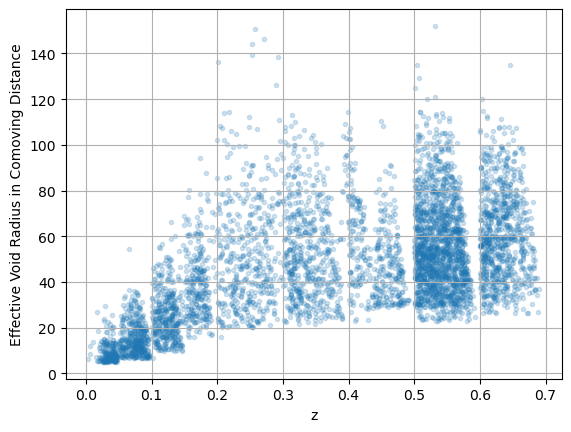

In [15]:
plt.scatter(voids.z, voids.Reff_Mpc, alpha=0.2, marker='.')
plt.xlabel("z")
plt.ylabel("Effective Void Radius in Comoving Distance")
plt.grid()

In [554]:
voids.columns

Index(['ID', 'RAdeg', 'DEdeg', 'z', 'Reff', 'DR', 'label', 'cmvd_Mpc',
       'Reff_Mpc', 'r_ang_deg'],
      dtype='object')

In [555]:
# test_voids = voids[:]['ID', 'RAdeg', 'DEdeg', 'z', 'Reff', 'cmvd_Mpc','Reff_Mpc', 'r_ang_deg']
test_voids = voids[:][['ID', 'RAdeg', 'DEdeg', 'z', 'Reff',
       'cmvd_Mpc', 'Reff_Mpc', 'r_ang_deg']]

In [1]:
# This may have been where I created voids.xlsx
test_voids.to_excel("exported_dataFrames/processed_voids.xlsx")
# Keeping processed label. This should be the exact same as data as in 
# voids.xlsx

NameError: name 'test_voids' is not defined

## Checking for uniqueness in Void data

In [557]:
# Check for unique IDs
id_count = Counter(voids['ID']) # Uh oh we have a few duplicate ID's
keys = list(id_count)
duplicate_ids = [keys for keys, count in id_count.items() if count>1]

In [558]:
id_count;

In [559]:
duplicates = voids[voids.duplicated()]
# print(duplicates)
# But pandas method says they are all unique. 

In [560]:
seps = {}
problematic = {}
# Loop through duplicate id's and determine if their angular seperation is less
# than 5 degrees
# Save duplicate void id. seperation, radius of each void and their redshift
for id in duplicate_ids:
    # Find index
    mask = voids['ID'].isin([id])
    table = voids[mask][:]
    RAs = table[:]['RAdeg'].values * u.deg
    DEs = table[:]['DEdeg'].values * u.deg
    coords = SkyCoord(RAs, DEs)
    temp_seps = dist_w_skycoord(coords)
    
    seps[str(id)] = temp_seps
    if min(temp_seps) < 5:
        problematic[str(id)] = {'seps': temp_seps,
                                'radius': table[:]['r_ang_deg'].values,
                                'z': table[:]['z'].values}

In [561]:
# Display problematic void id's
problematic; # Two duplicate id's were problematic

In [562]:
# Not used anywhere else in the code. Will probably get deleted
# duplicate_mask = voids['ID'].isin(duplicate_ids)

In [563]:
# Void coordinates in celestial frame
void_coords_cel = SkyCoord(voids['RAdeg'].values*u.deg,
                       voids['DEdeg'].values*u.deg,
                       equinox='J2000')

In [564]:
# Out of curiosity. I wanted to see what a histogram for void seperations would
# look like. 
# void_seps = dist_w_skycoord(void_coords_cel) #plot super anisotropic


Notes on Void Catalog from 2017:
    ZOBOV void finding algorithm
    10,643 before "quality cuts"
    1,228 Voids after "quality cuts" 
    effective radii spanning 20-100 Mpc/h
    Uses SDSS DR 12 CMASS and LOWZ galaxy samples
    z: 0.2 - 0.43 LOWZ Sample cut
    z: 0.43 - 0.7 CMASS sample cut
    z: 0.2 - 0.7 total 

    
Notes on Void Catalog from 2012:
    z: 0.2 - 0.44
    Uses main sample and lumious red galaxy (LRG) from SDSS DR 7
    Effective radii 5 - 135 Mpc/h
    Modified Version of ZOBOV (parameter free)

    

# VHE Data Processing

## Cleaning Data

In [565]:
# import packages
fhl3 = fits.open('3FHL.fit')

In [566]:
# Determine where data is stored in fits file
# FERMI DATA USES FK5 FRAME WRONG
# Equatorial
fhl3.info() # Used to see scope of data
w = wcs.WCS(fhl3[1].header)
print(w) # Used to find out what frame the data uses
# w.world_axis_physical_types

hdu = fits.open('3FHL.fit')[1]
wcs = WCS(hdu.header)

Filename: 3FHL.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  LAT_Point_Source_Catalog    1 BinTableHDU    258   1556R x 44C   [18A, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, 11A, E, E, E, E, E, E, 5E, 10E, 5E, 5E, E, E, E, I, 18A, 18A, A, 21A, 7A, 26A, 26A, E, E, E, E]   
  2  ExtendedSources    1 BinTableHDU     82   55R x 11C   [17A, E, E, E, E, 11A, E, E, E, 11A, 24A]   
  3  ROIs          1 BinTableHDU    103   741R x 10C   [I, E, E, E, E, E, E, E, E, E]   
  4  EnergyBounds    1 BinTableHDU     48   5R x 3C   [E, E, E]   
WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 366  1556


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 57236.967546 from DATE-END'. [astropy.wcs.wcs]


In [567]:
# Read in 3FHL Fits file
data = QTable.read('3FHL.fit', hdu=1)

In [568]:
data  # Used to see data table 

Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Signif_Avg,Pivot_Energy,Flux_Density,Unc_Flux_Density,Flux,Unc_Flux,Energy_Flux,Unc_Energy_Flux,Signif_Curve,SpectrumType,Spectral_Index,Unc_Spectral_Index,beta,Unc_beta,PowerLaw_Index,Unc_PowerLaw_Index,Flux_Band,Unc_Flux_Band,nuFnu,Sqrt_TS_Band,Npred,HEP_Energy,HEP_Prob,Variability_BayesBlocks,Extended_Source_Name,ASSOC_GAM,TEVCAT_FLAG,ASSOC_TEV,CLASS,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,Redshift,NuPeak_obs
,deg,deg,deg,deg,deg,deg,deg,,,GeV,ph / (GeV s cm2),ph / (GeV s cm2),ph / (s cm2),ph / (s cm2),erg / (s cm2),erg / (s cm2),,,,,,,,,ph / (s cm2),ph / (s cm2),erg / (s cm2),,,GeV,,,,,,,,,,,,,Hz
bytes18,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes11,float32,float32,float32,float32,float32,float32,float32[5],"float32[5,2]",float32[5],float32[5],float32,float32,float32,int16,bytes18,bytes18,bytes1,bytes21,bytes7,bytes26,bytes26,float32,float32,float32,float32
3FHL J0001.2-0748,0.3107,-7.8075,89.0094,-67.3118,0.0424,0.0424,———,64,5.362,23.73,5.3174e-13,2.0975e-13,2.9593e-11,1.1704e-11,1.6752e-12,1.0743e-12,1.02,PowerLaw,1.6724,0.8274,0.5916,0.7129,2.2226,0.4808,1.1127661292409385e-11 .. 1.142230074863933e-22,-6.076397631588071e-12 .. 6.529277118971777e-12,3.53398896518059e-13 .. 1.1789071844646614e-22,3.1458344 .. 0.0,7.63,86.975,0.9964,1,,3FGL J0001.2-0748,N,,bll,PMN J0001-0746,,0.9974,0.9721,--,306196372258816.0
3FHL J0001.9-4155,0.4849,-41.9303,334.1216,-72.0697,0.1018,0.1018,———,429,5.638,28.42,5.4253e-13,1.6839e-13,4.3230e-11,1.3428e-11,3.4900e-12,1.8276e-12,0.45,PowerLaw,1.7819,0.4941,0.1187,0.2798,1.9418,0.3100,2.1003905212313434e-11 .. 1.928788526283026e-18,-8.032090617615673e-12 .. 5.859409745595512e-12,6.745224496139401e-13 .. 2.0786751008437066e-18,4.899907 .. 0.0,12.51,266.625,0.9622,1,,3FGL J0002.2-4152,N,,bcu,1RXS J000135.5-415519,,0.9960,0.0000,--,6309576467021824.0
3FHL J0002.1-6728,0.5283,-67.4825,310.0868,-48.9549,0.0357,0.0357,———,386,8.470,20.82,1.2062e-12,3.2106e-13,5.0093e-11,1.3349e-11,2.3058e-12,9.5580e-13,1.53,PowerLaw,1.8109,0.6260,0.7933,0.5956,2.4285,0.3710,2.4550663585420907e-11 .. 1.9009975647596715e-21,-8.634194921530725e-12 .. 4.802190329417089e-12,7.734069461251547e-13 .. 1.9026535415719115e-21,5.900217 .. 0.0,17.11,52.152,0.9988,1,,3FGL J0002.0-6722,N,,bcu,SUMSS J000215-672653,,0.0000,0.9395,--,4466832022962176.0
3FHL J0003.3-5248,0.8300,-52.8150,318.9245,-62.7936,0.0425,0.0425,———,145,7.229,23.66,7.5065e-13,2.3102e-13,4.1560e-11,1.2839e-11,2.2874e-12,1.1145e-12,1.70,PowerLaw,1.6010,0.5644,0.9972,0.1721,2.2481,0.3732,2.0886386370433385e-11 .. 7.586755528904005e-23,-8.143967271390107e-12 .. 5.312990065259315e-12,6.626545557934793e-13 .. 7.800201726106361e-23,5.298393 .. 0.0,13.02,67.310,0.9636,1,,3FGL J0003.2-5246,N,,bcu,RBS 0006,,0.9996,0.9716,--,7.079464172466995e+16
3FHL J0007.0+7303,1.7647,73.0560,119.6625,10.4666,0.0101,0.0101,———,277,75.265,12.80,1.7436e-10,7.5950e-12,1.5308e-09,6.1341e-11,3.6785e-11,1.5973e-12,3.24,LogParabola,3.1751,0.2103,0.9021,0.2659,3.8315,0.1141,1.3514667163150307e-09 .. 3.839894826201812e-18,-5.7581186346800095e-11 .. 4.060417800599847e-12,4.109738938051777e-11 .. 2.923114423287347e-18,71.33829 .. 0.0,654.15,60.292,0.9972,1,,3FGL J0007.0+7302,E,CTA 1,PSR,LAT PSR J0007+7303,,1.0000,0.0000,--,———
3FHL J0007.9+4711,1.9931,47.1920,115.3093,-15.0354,0.0196,0.0196,———,302,17.774,17.19,5.9778e-12,8.7683e-13,1.5131e-10,2.2181e-11,5.1444e-12,1.0540e-12,0.56,PowerLaw,2.6783,0.4196,0.1696,0.3282,2.8588,0.2685,1.0582407172776698e-10 .. 1.9819722609314394e-16,-1.7538378735415527e-11 .. 4.823510948298582e-12,3.278615009691399e-12 .. 1.866829778455242e-16,15.209969 .. 0.0,50.95,68.152,0.9759,1,,3FGL J0008.0+4713,N,,bll,MG4 J000800+4712,,1.0000,0.9873,0.2800,2511884242649088.0
3FHL J0008.4-2339,2.1243,-23.6514,50.2908,-79.7021,0.0366,0.0366,———,517,9.679,16.96,3.0610e-12,7.3475e-13,7.46

In [569]:
# Clean 3FHL data to galactic sources only
class_data = data['CLASS']

# mask = (class_data == 'sbg    ') | \
#        (class_data == 'bll    ') | \
#        (class_data == 'fsrq   ') | \
#        (class_data == 'agn    ') | \
#        (class_data == 'rdg    ') | \
#        (class_data == 'bcu    ') # Ugly but it works

anti_mask = ~((class_data == 'psr    ') | \
              (class_data == 'PSR    ') | \
              (class_data == 'pwn    ') | \
              (class_data == 'PWN    ') | \
              (class_data == 'snr    ') | \
              (class_data == 'SNR    ') | \
              (class_data == 'hmb    ') | \
              (class_data == 'HMB    ') | \
              (class_data == 'BIN    ') | \
              (class_data == 'sfr    ') | \
              (class_data == 'SFR    ')
              ) # Ugly but it works

gal_src = data[anti_mask] # Cleaned 3FHL data that contains data from galactic sources only

In [570]:
Counter(gal_src['CLASS']); # Matches Table 2 in 3FHL Paper we are good to go

In [571]:
# Filtering out sources without Redshift information
z_data = gal_src['Redshift']
z_mask = ~np.ma.getmaskarray(z_data) # z data is float, if no z data, it is an np.ma.mask object
gal_src_wz = gal_src[z_mask] # Galactic Sources with redshift information

Max z: 2.5339999198913574
Min z: 0.003000000026077032
Range: 2.5309998989105225 


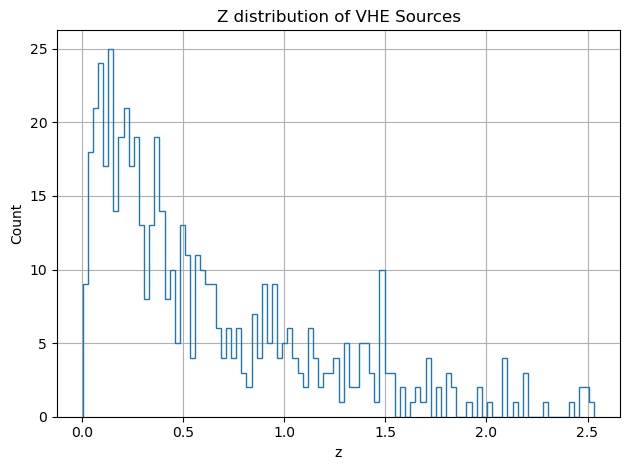

In [572]:
# Plots histogram of Gamma Ray Source Redshift Distribution
plt.hist(gal_src_wz['Redshift'], bins=100, histtype="step") # 100 bins chosen arbitrarily
plt.xlabel('z')
plt.ylabel('Count')
plt.title('Z distribution of VHE Sources')
plt.grid()
plt.tight_layout()

# z range
max_z = gal_src_wz['Redshift'].max()
min_z = gal_src_wz['Redshift'].min()
print(f"Max z: {max_z}\nMin z: {min_z}\nRange: {max_z - min_z} ")

Plot of Redshift distribution for extra galactic gamma ray sources

## X-ray AGN data processing

In [1]:
#
# It was sourced from here
# https://heasarc.gsfc.nasa.gov/W3Browse/all/swbatagn60.html
# 
# We may potentially add to the study
# This is a different catalog
# https://heasarc.gsfc.nasa.gov/W3Browse/swift/swift2sxps.html
#
# 
# Read in table as pandas df
xagn_fn = 'agn data/agn.xlsx' # Assuming the data is already parsed as excel file
x_agn = pd.read_excel(xagn_fn)

# Rename columns to match convention of rest of code.
column_mapping = { # Extra space is an artefact of how the text file is converted into excel. The spaces are kept in case new data tables from the same source are tested
    'name': 'Source_Name', # This one is the only one manipulated in the excel table
    'ra': 'RAdeg',
    'dec' : 'DEdeg',
    'flux': 'Flux',
    'redshift': 'z',
    'lii': 'Gal_Long',
    "bii" :'Gal_Lat'
}
x_agn = x_agn.rename(columns=column_mapping)

# # Force data to be numeric
# columns_to_convert = ['Redshift', 'Flux', 'error_radius']

# # Convert from strings to numbers
# x_agn[columns_to_convert] = x_agn[columns_to_convert].apply(pd.to_numeric, errors='coerce')
# # Remove AGNs with no Redshift Info
# x_agn = x_agn[x_agn.Redshift.notna()] # Eliminates 9 AGNs


# add 'TEVCAT_FLAG' column where everything is flase. This is to make the table compatible with previous code
x_agn['TEVCAT_FLAG'] = False

NameError: name 'pd' is not defined

In [601]:
x_agn.to_excel('exported_dataFrames/xray_agns.xlsx', index=False)

In [575]:
def hmsSTR_to_dd(str_array, radec):

    
    """Convert the input Hour minute seconds string
    redec : str ,'ra' if input array is ra, 'dec' for dec' """
    dd_array = np.zeros_like(str_array)

    h_2_deg = 360/24

    if radec == 'ra':
        # "Format 'hh mm ss'
        # or      '01234567' hence, the slice
        m_2_deg = (24/60) * h_2_deg
        s_2_deg = (1/3600) * h_2_deg
        for i in range(len(dd_array)):
            h = float(str_array[i][0:2])
            m = float(str_array[i][3:5])
            s = float(str_array[i][6:])
            # Uncertainties on the conversion?
            dd_array[i] = h * h_2_deg + m * m_2_deg + s * s_2_deg

    elif radec == 'dec':
        # Format '±dg dd' Degree decimal
        # Degrees minutes
        for i in range(len(dd_array)):
            sign = str_array[i][0]
            dd = float(str_array[i][1:3]) + float(str_array[i][4:])

            if sign == '-':
                dd = -dd
                # otherwise it just stays as a positive value
            
            dd_array[i] = dd
    
    else:
        raise Exception("Ayo. 'radec is either 'ra' for RA and 'dec' ")
    return dd_array



In [576]:
# Turn the string Ra dec information to floats
# x_agn.RAJ2000 = hmsSTR_to_dd(x_agn.RAJ2000.values, radec='ra')
# x_agn.DEJ2000 = hmsSTR_to_dd(x_agn.DEJ2000.values, radec='dec')
# No longer needed since excel alrady comes with coordinates in dec degs

## Analysis

In [577]:
ahh = gal_src_wz
temp =ahh[:]['Source_Name','RAJ2000', 'DEJ2000', 'Redshift', 
             'TEVCAT_FLAG',
             'Spectral_Index', 'Unc_Spectral_Index',
             'Flux', 'Unc_Flux',
             ] 

In [578]:
type(temp[:]['Source_Name'])

astropy.table.column.Column

In [579]:
fn = "cel_obj_table.xlsx"
test = temp[:]['Source_Name','RAJ2000', 'DEJ2000', 'Redshift']
type(temp)

astropy.table.table.QTable

In [580]:

# Strictly Sticking to voidiness analysis we only need  positional data
test = test.to_pandas()
test.to_excel(fn)

In [581]:

# This is where I can slip in the X-ray AGN data. I will have to restructure the code to have both data sets run through analysis
# and have the data available
vhe_flag = True
if vhe_flag:    
    work_vhe = temp.to_pandas() # Create GRS pandas table to work with throughout the code
else:
    work_vhe = x_agn.copy() # The ol' switcharoo. Switch to x_agn data


# Flux_Band presents multidimensional issues
# UPDATE https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy This link might help. pandas is capable of multidimensional columns
problem = ahh[:]['Flux_Band'].value
problem2 = ahh[:]['Unc_Flux_Band'].value

problem = np.vstack(problem) # This seems to do it
problem2 = np.reshape(problem2,(problem2.shape[0], -1)) # This puts them right next to each other so 1a 1b 2a 2b

col_names_flux = [f"Flux_Band_{band}" for band in range(5)]
col_names_unc = [f"Unc_Flux_Band_{band}_{state}" for band in range(5) for state in ['a', 'b']]

flux_band_df = pd.DataFrame(problem, columns=col_names_flux)
unc_df = pd.DataFrame(problem2, columns=col_names_unc)


In [582]:
unc_df


,Unc_Flux_Band_0_a,Unc_Flux_Band_0_b,Unc_Flux_Band_1_a,Unc_Flux_Band_1_b,Unc_Flux_Band_2_a,Unc_Flux_Band_2_b,Unc_Flux_Band_3_a,Unc_Flux_Band_3_b,Unc_Flux_Band_4_a,Unc_Flux_Band_4_b
0,-1.753838e-11,1.962841e-11,-9.966651e-12,1.200368e-11,-4.337763e-12,6.349509e-12,NaN,4.490274e-12,NaN,4.823511e-12
1,-1.441937e-11,1.709378e-11,-6.326369e-12,9.159056e-12,-2.537723e-12,4.969067e-12,NaN,5.550699e-12,NaN,6.106610e-12
2,-8.030480e-12,1.096500e-11,-6.018418e-12,8.886387e-12,NaN,5.580639e-12,NaN,5.594342e-12,NaN,6.247885e-12
3,-9.441283e-12,1.137569e-11,-7.155109e-12,9.591453e-12,-4.597607e-12,6.873026e-12,NaN,4.970725e-12,NaN,5.700210e-12
4,-9.450762e-12,1.224237e-11,-9.456738e-12,1.243328e-11,-4.176813e-12,6.519807e-12,NaN,5.628899e-12,NaN,6.531485e-12
...,...,...,...,...,...,...,...,...,...,...
543,-1.423078e-11,1.698324e-11,-5.583069e-12,8.268098e-12,-2.834740e-12,5.295051e-12,NaN,5.649443e-12,NaN,6.211813e-12
544,-8.926376e-12,1.163099e-11,-8.010795e-12,1.051626e-11,NaN,6.736748e-12,NaN,5.746926e-12,NaN,6.097474e-12
545,-8.514681e-12,1.088811e-11,-3.984897e-12,6.248356e-12,-4.476456e-12,6.505365e-12,-2.156329e-12,4.329094e-12,NaN,5.413462e-12
546,-1.360454e-11,1.620427e-11,-6.375197e-12,8.814114e-12,-5.793347e-12,8.311956e-12,NaN,6.358848e-12,NaN,8.488618e-12


In [583]:
unc_df = unc_df.astype(np.float64) # VERY unexpected bug. different data types caused issues

# Only concat if we're working with VHE GRS
if vhe_flag:
    work_vhe = pd.concat([work_vhe ,flux_band_df, unc_df], axis=1) # This is where I concat GRS data


In [584]:
work_vhe

,Source_Name,RAJ2000,DEJ2000,Redshift,TEVCAT_FLAG,Spectral_Index,Unc_Spectral_Index,Flux,Unc_Flux,Flux_Band_0,...,Unc_Flux_Band_0_a,Unc_Flux_Band_0_b,Unc_Flux_Band_1_a,Unc_Flux_Band_1_b,Unc_Flux_Band_2_a,Unc_Flux_Band_2_b,Unc_Flux_Band_3_a,Unc_Flux_Band_3_b,Unc_Flux_Band_4_a,Unc_Flux_Band_4_b
0,b'3FHL J0007.9+4711 ',1.993146,47.191978,0.28000,b'N',2.678279,0.419624,1.513089e-10,2.218131e-11,1.058241e-10,...,-1.753838e-11,1.962841e-11,-9.966651e-12,1.200368e-11,-4.337763e-12,6.349509e-12,NaN,4.490274e-12,NaN,4.823511e-12
1,b'3FHL J0008.4-2339 ',2.124295,-23.651365,0.14700,b'N',2.738774,0.714455,7.460176e-11,1.789602e-11,5.804992e-11,...,-1.441937e-11,1.709378e-11,-6.326369e-12,9.159056e-12,-2.537723e-12,4.969067e-12,NaN,5.550699e-12,NaN,6.106610e-12
2,b'3FHL J0013.8-1855 ',3.468434,-18.916901,0.09500,b'P',1.943785,0.916421,3.108575e-11,1.194516e-11,1.876132e-11,...,-8.030480e-12,1.096500e-11,-6.018418e-12,8.886387e-12,NaN,5.580639e-12,NaN,5.594342e-12,NaN,6.247885e-12
3,b'3FHL J0018.6+2946 ',4.652533,29.782143,0.10000,b'N',1.680245,0.490069,5.057661e-11,1.449517e-11,2.360333e-11,...,-9.441283e-12,1.137569e-11,-7.155109e-12,9.591453e-12,-4.597607e-12,6.873026e-12,NaN,4.970725e-12,NaN,5.700210e-12
4,b'3FHL J0030.2-1648 ',7.572597,-16.800194,2.10000,b'C',1.624639,0.490165,5.981311e-11,1.610502e-11,2.610014e-11,...,-9.450762e-12,1.224237e-11,-9.456738e-12,1.243328e-11,-4.176813e-12,6.519807e-12,NaN,5.628899e-12,NaN,6.531485e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,b'3FHL J2347.9-1630 ',356.997833,-16.510584,0.57600,b'N',3.125928,0.778131,6.758524e-11,1.747791e-11,5.251989e-11,...,-1.423078e-11,1.698324e-11,-5.583069e-12,8.268098e-12,-2.834740e-12,5.295051e-12,NaN,5.649443e-12,NaN,6.211813e-12
544,b'3FHL J2350.5-3006 ',357.635376,-30.107038,0.22368,b'N',2.101194,0.617267,4.703938e-11,1.427381e-11,2.193922e-11,...,-8.926376e-12,1.163099e-11,-8.010795e-12,1.051626e-11,NaN,6.736748e-12,NaN,5.746926e-12,NaN,6.097474e-12
545,b'3FHL J2356.2+4035 ',359.074554,40.598537,0.13100,b'N',2.023282,0.424173,4.340044e-11,1.251094e-11,2.577773e-11,...,-8.514681e-12,1.088811e-11,-3.984897e-12,6.248356e-12,-4.476456e-12,6.505365e-12,-2.156329e-12,4.329094e-12,NaN,5.413462e-12
546,b'3FHL J2359.1-3038 ',359.775970,-30.639738,0.16500,b'P',2.286517,0.463157,8.177407e-11,1.814947e-11,5.501562e-11,...,-1.360454e-11,1.620427e-11,-6.375197e-12,8.814114e-12,-5.793347e-12,8.311956e-12,NaN,6.358848e-12,NaN,8.488618e-12


In [585]:

work_vhe = work_vhe.rename(columns={'RAJ2000': 'RAdeg',
                                    'DEJ2000': 'DEdeg',
                                    'Redshift': 'z'}) # MUST BE CONSISTENT WITH CONVENTION USED IN DATAPARSER

vhe_cmvd = cosmo.comoving_distance(work_vhe['z']) # Comoving distance to void center
work_vhe['cmvd_Mpc'] = vhe_cmvd.value # add it to data table

# Find sources in front of our furthest voids
mask_z = work_vhe['z'] <= max(voids.z)

# Keep those sources
work_vhe = work_vhe[mask_z] # After this mask. we drop to 367 sources


work_vhe = work_vhe.reset_index(drop=True)


In [586]:
work_vhe

,Source_Name,RAdeg,DEdeg,z,TEVCAT_FLAG,Spectral_Index,Unc_Spectral_Index,Flux,Unc_Flux,Flux_Band_0,...,Unc_Flux_Band_0_b,Unc_Flux_Band_1_a,Unc_Flux_Band_1_b,Unc_Flux_Band_2_a,Unc_Flux_Band_2_b,Unc_Flux_Band_3_a,Unc_Flux_Band_3_b,Unc_Flux_Band_4_a,Unc_Flux_Band_4_b,cmvd_Mpc
0,b'3FHL J0007.9+4711 ',1.993146,47.191978,0.28000,b'N',2.678279,0.419624,1.513089e-10,2.218131e-11,1.058241e-10,...,1.962841e-11,-9.966651e-12,1.200368e-11,-4.337763e-12,6.349509e-12,NaN,4.490274e-12,NaN,4.823511e-12,1134.609645
1,b'3FHL J0008.4-2339 ',2.124295,-23.651365,0.14700,b'N',2.738774,0.714455,7.460176e-11,1.789602e-11,5.804992e-11,...,1.709378e-11,-6.326369e-12,9.159056e-12,-2.537723e-12,4.969067e-12,NaN,5.550699e-12,NaN,6.106610e-12,615.058744
2,b'3FHL J0013.8-1855 ',3.468434,-18.916901,0.09500,b'P',1.943785,0.916421,3.108575e-11,1.194516e-11,1.876132e-11,...,1.096500e-11,-6.018418e-12,8.886387e-12,NaN,5.580639e-12,NaN,5.594342e-12,NaN,6.247885e-12,402.292100
3,b'3FHL J0018.6+2946 ',4.652533,29.782143,0.10000,b'N',1.680245,0.490069,5.057661e-11,1.449517e-11,2.360333e-11,...,1.137569e-11,-7.155109e-12,9.591453e-12,-4.597607e-12,6.873026e-12,NaN,4.970725e-12,NaN,5.700210e-12,422.982362
4,b'3FHL J0033.5-1921 ',8.392931,-19.357483,0.61000,b'P',1.915807,0.194235,4.384046e-10,4.202211e-11,2.346781e-10,...,3.234633e-11,-2.246991e-11,2.524404e-11,-1.286299e-11,1.534902e-11,-4.109210e-12,6.613589e-12,NaN,6.343457e-12,2271.573244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,b'3FHL J2347.9-1630 ',356.997833,-16.510584,0.57600,b'N',3.125928,0.778131,6.758524e-11,1.747791e-11,5.251989e-11,...,1.698324e-11,-5.583069e-12,8.268098e-12,-2.834740e-12,5.295051e-12,NaN,5.649443e-12,NaN,6.211813e-12,2164.105485
363,b'3FHL J2350.5-3006 ',357.635376,-30.107038,0.22368,b'N',2.101194,0.617267,4.703938e-11,1.427381e-11,2.193922e-11,...,1.163099e-11,-8.010795e-12,1.051626e-11,NaN,6.736748e-12,NaN,5.746926e-12,NaN,6.097474e-12,918.956936
364,b'3FHL J2356.2+4035 ',359.074554,40.598537,0.13100,b'N',2.023282,0.424173,4.340044e-11,1.251094e-11,2.577773e-11,...,1.088811e-11,-3.984897e-12,6.248356e-12,-4.476456e-12,6.505365e-12,-2.156329e-12,4.329094e-12,NaN,5.413462e-12,550.162534
365,b'3FHL J2359.1-3038 ',359.775970,-30.639738,0.16500,b'P',2.286517,0.463157,8.177407e-11,1.814947e-11,5.501562e-11,...,1.620427e-11,-6.375197e-12,8.814114e-12,-5.793347e-12,8.311956e-12,NaN,6.358848e-12,NaN,8.488618e-12,687.456671


In [587]:
work_vhe.to_excel('exported_dataFrames/GRS.xlsx', index = False )

In [588]:

if vhe_flag: # Seems like the flag is no longer necessary here
    frm = 'fk5'
else:
    frm = 'icrs'

vhe_coords_cel = SkyCoord(work_vhe.RAdeg.values*u.deg, work_vhe.DEdeg.values * u.deg, equinox='J2000', frame=frm)
vhe_coords_gal =  vhe_coords_cel.galactic # book keeping. Source coords in galactic coords
work_vhe['RAdeg_gal'] = vhe_coords_gal.l.deg
work_vhe['DEdeg_gal'] = vhe_coords_gal.b.deg
# work_vhe['RAdeg'] += 45

# This mask is a general mask
# Apply SDSS footprint mask
m1 = ~get_mask(work_vhe,
                  RA_lo=0, RA_hi=110,
                  DE_lo=32)

m2 = ~get_mask(work_vhe,
                  DE_lo=65)
m3 = ~get_mask(work_vhe,
                   DE_hi=-10)
m4 = ~get_mask(work_vhe,
                  RA_lo=270,
                  RA_hi=315)
m5 = ~get_mask(work_vhe,
               RA_hi=270,
               RA_lo=262)
m6 = ~get_mask(work_vhe,
               RA_lo=265,
               DE_lo=37)
m7 =  ~get_mask(work_vhe,
                RA_lo=45,
                RA_hi=100)
m8 = ~get_mask(work_vhe,
               RA_lo=225,
               RA_hi=320,
               DE_hi=0)
m9 = ~get_mask(work_vhe,
               RA_lo = 45,
               RA_hi=182,
               DE_hi=0)
m10 = ~get_mask(work_vhe,
                RA_lo=315,
                DE_hi=-5)
m11 = ~get_mask(work_vhe,
                RA_lo=10,
                RA_hi=15,
                DE_hi=9)
#
# Removing Mao voids leaves GRS in segue footprint. We now need to remove these
#
mSegue1 = ~get_mask(work_vhe,
                   RA_hi=50,
                   DE_lo=-35)
mSegue2 = ~get_mask(work_vhe,
                    RA_lo=310,
                    DE_lo=-10)
m = get_ands([m1,
              m2,
              m3,
              m4,
              m5,
              m6,
              m7,
              m8,
              m9,
              m10,
              m11,
              mSegue1,
              mSegue2])
work_vhe = work_vhe[m].copy()

# Need to do this again for x-rays

# Indices of gamma ray sources that fall outside of SDSS footprint
exclude = [21,
           98,
           90,
           107,
           279,
           277,
           278,
           241,
           257,
           325,
           45,
           40,
           33,
           35,
           31,
           36,
           29,
           # Removing Mao voids also shrunk our footprint's perimeter a bit
           88,
           97,
           102,
           208,
           187,
           184,
           186,
           96,
           115,
        #    113, # Does seem to appear to be in the void footprint
           100,
           109,
           173,
           129,
           144,
           199,
           234,
           232,
           261,
           265,
           267,
           273,
           264
           ] # These are unique to VHEs

# Final Gamma Ray Source table after table has been cleaned against galactic mask
# and data outside of SDSS footprint has been removed.

# This is for x-ray galaxies. These are the list of indices of x-ray galaxies that fall outside of 
exclude_xray = [198,
                #309, # This one looks good
                335,
                322, # Sneaky. This one sits on top of another
                321, # Sits on top of the previous
                295, # This one is a maybe
                297, # Also a maybe
                # 357. Tested its good
                # 356, # Looks good too
                354,
                369,
                365,
                358,
                279, # This one is a maybe. Check
                283,
                258,
                263,
                265,
                244,
                278
                ]
# Theres still a few to take out
if vhe_flag:
    work_vhe = work_vhe.loc[~work_vhe.index.isin(exclude)] 
else:
    work_vhe = work_vhe.loc[~work_vhe.index.isin(exclude_xray)]
    



In [589]:
# Adding the original index numbers to check if my index method is working as 
# intended. In general, the actual index of the data should match OG_index
# I can not save this before because i reset the indices before applying the
# SDSS mask. I would have to redo the SDSS mask with the original indices. 
work_vhe.insert(0, 'OG_idx', work_vhe.index)

In [590]:
# Display table
work_vhe # Compared to the footprint filtered GRS has 117 voids. 

,OG_idx,Source_Name,RAdeg,DEdeg,z,TEVCAT_FLAG,Spectral_Index,Unc_Spectral_Index,Flux,Unc_Flux,...,Unc_Flux_Band_1_b,Unc_Flux_Band_2_a,Unc_Flux_Band_2_b,Unc_Flux_Band_3_a,Unc_Flux_Band_3_b,Unc_Flux_Band_4_a,Unc_Flux_Band_4_b,cmvd_Mpc,RAdeg_gal,DEdeg_gal
101,101,b'3FHL J0754.8+4822 ',118.709427,48.381851,0.37671,b'N',1.844553,0.477081,6.366334e-11,1.414227e-11,...,9.273509e-12,NaN,5.174297e-12,NaN,4.356179e-12,NaN,4.641887e-12,1489.985058,170.569883,30.154120
105,105,b'3FHL J0809.7+3457 ',122.429825,34.958000,0.08300,b'C',1.537894,0.398432,3.762599e-11,1.178684e-11,...,8.085367e-12,-3.622594e-12,5.682121e-12,-2.196309e-12,4.270880e-12,NaN,5.413912e-12,352.435772,186.447142,30.370766
106,106,b'3FHL J0809.8+5218 ',122.458603,52.310394,0.13800,b'P',2.085875,0.150503,5.031846e-10,3.784231e-11,...,2.006459e-11,-1.311989e-11,1.522318e-11,-4.510572e-12,6.316802e-12,NaN,4.493836e-12,578.617295,166.252082,32.912325
110,110,b'3FHL J0816.9+2050 ',124.236435,20.847292,0.05800,b'N',1.687501,0.694033,3.335314e-11,1.233066e-11,...,9.271541e-12,-2.308233e-12,4.485689e-12,NaN,5.143181e-12,NaN,6.364596e-12,247.668418,202.424760,27.738667
111,111,b'3FHL J0818.2+4222 ',124.562164,42.376682,0.53000,b'N',2.579031,0.410084,2.336202e-10,2.770750e-11,...,1.566809e-11,-2.063953e-12,4.012071e-12,NaN,4.484594e-12,NaN,4.872048e-12,2015.283912,178.230310,33.398329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,266,b'3FHL J1607.0+1550 ',241.756088,15.835721,0.49600,b'N',3.177758,0.790509,6.020107e-11,1.460740e-11,...,8.727400e-12,-2.044046e-12,4.266526e-12,NaN,4.624338e-12,NaN,5.071932e-12,1902.710656,29.337635,43.418285
268,268,b'3FHL J1626.2+3515 ',246.574768,35.262291,0.49738,b'N',1.318621,0.691001,2.254689e-11,9.101243e-12,...,8.785571e-12,-2.051363e-12,3.925008e-12,NaN,4.401563e-12,NaN,4.984420e-12,1907.322882,56.963032,43.892147
271,271,b'3FHL J1642.9+3948 ',250.734909,39.814907,0.59300,b'N',1.905996,0.506023,6.053068e-11,1.508011e-11,...,1.019531e-11,-3.750062e-12,5.456328e-12,NaN,5.645884e-12,NaN,4.868356e-12,2218.105586,63.460492,40.956902
274,274,b'3FHL J1652.7+4024 ',253.194107,40.403389,0.24000,b'N',1.596837,0.748321,3.324196e-11,1.183103e-11,...,9.128316e-12,NaN,5.811772e-12,NaN,5.890670e-12,NaN,4.813395e-12,982.107172,64.401557,39.122618


In [591]:
# Generate Skycoord Objects
# Skycoords of GRS in celestial
# Turns outs the fermi data is in equatorial frame
vhe_coords_cel = SkyCoord(work_vhe.RAdeg.values*u.deg, work_vhe.DEdeg.values * u.deg, 
                          equinox='J2000', 
                          frame='fk5')
vhe_coords_gal =  vhe_coords_cel.galactic # book keeping. Source coords in galactic coords

void_coords_gal = void_coords_cel.galactic # Moore bookkeeping. Skycoord of voids in galactic

seps = vhe_coords_cel.separation(vhe_coords_cel) # This returns the expected 0 seperation
Counter(vhe_coords_cel.separation(vhe_coords_cel)); # Confirming they are all 0 and array length matches source array


In [592]:
# Apply galactic mask
# # Find fermi data with |b| < 10
MASK_deg = 10 # Degrees. global constant
masked = False
if masked:
    mask_fermi = abs(vhe_coords_gal.b.value) <= MASK_deg

    # Keep the sources with |b| > 10
    vhe_coords_gal = vhe_coords_gal[~mask_fermi] # Drops 20 sources
    vhe_coords_cel = vhe_coords_gal.fk5 # Bookkeping. Go back to Celestial coordinates

In [593]:
work_vhe.columns

Index(['OG_idx', 'Source_Name', 'RAdeg', 'DEdeg', 'z', 'TEVCAT_FLAG',
       'Spectral_Index', 'Unc_Spectral_Index', 'Flux', 'Unc_Flux',
       'Flux_Band_0', 'Flux_Band_1', 'Flux_Band_2', 'Flux_Band_3',
       'Flux_Band_4', 'Unc_Flux_Band_0_a', 'Unc_Flux_Band_0_b',
       'Unc_Flux_Band_1_a', 'Unc_Flux_Band_1_b', 'Unc_Flux_Band_2_a',
       'Unc_Flux_Band_2_b', 'Unc_Flux_Band_3_a', 'Unc_Flux_Band_3_b',
       'Unc_Flux_Band_4_a', 'Unc_Flux_Band_4_b', 'cmvd_Mpc', 'RAdeg_gal',
       'DEdeg_gal'],
      dtype='object')

In [594]:
test = work_vhe[:][['Source_Name', 'RAdeg', 'DEdeg', 'cmvd_Mpc', 'RAdeg_gal',
       'DEdeg_gal']]
test.to_excel("cel_obj_table.xlsx")

### Plot Gamma-Ray Sources and Voids

/var/folders/pj/_3cv5_xd2sz143_b3_wm1xk40000gn/T/ipykernel_2387/4017705872.py:65: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [30]  # Adjust the marker size for the Cosmic Voids label


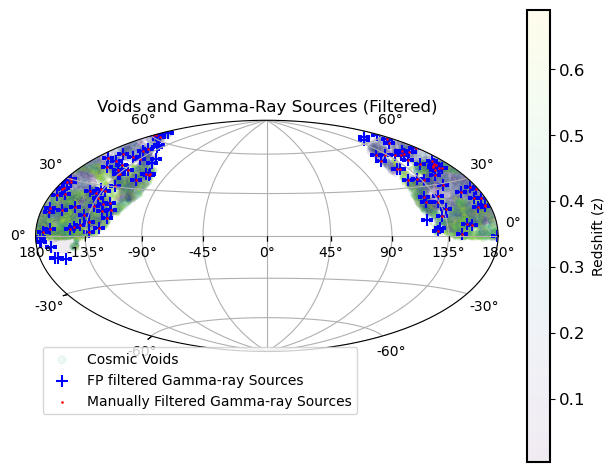

In [595]:

# Plot Sources in galactic frame

# fig = plt.figure(figsize=(8, 4))

ax = plt.axes(projection="geo aitoff")
# ax = plt.axes(projection='astro zoom',
#               center='12h -32d', radius='5 deg', rotate='5 deg')

ax.grid()


# ax = fig.add_subplot(111, projection='geo aitoff')

# ax.xaxis.set_major_locator(plt.FixedLocator([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]))  # Example for longitude
# ax.yaxis.set_major_locator(plt.FixedLocator([-1.0, -0.5, 0.0, 0.5, 1.0]))  # Example for latitude

r_ang = voids[:]['r_ang_deg']
z_values = voids['z']
norm = Normalize(vmin=min(z_values), vmax=max(z_values))

colormap = 'viridis' 


# TODO: Check coordinate systems for both catalogs.
scatter = ax.scatter(voids.RAdeg, voids.DEdeg,
                     transform=ax.get_transform('world'),
                     s=math.pi*r_ang**2,
                     marker='o',
                     label='Cosmic Voids',
                     c=voids['z'],  # Use the redshift values directly
                     cmap=colormap,  # Set the colormap
                     alpha=0.08)

# Set color limits to match data range
vmin = min(voids['z'])
vmax = max(voids['z'])
scatter.set_clim(vmin, vmax)


# read in footprint filtered GRS and compar
fp_filtered_Grs = pd.read_excel('exported_dataFrames/footprint_filtered_GRS.xlsx')

ax.scatter(fp_filtered_Grs.RAdeg, fp_filtered_Grs.DEdeg,
           transform=ax.get_transform('world'),
           marker="+",
           facecolor='blue',
           s =75,
           label='FP filtered Gamma-ray Sources'
          )
#
# plotting directly from the work_vhe table instead of a copy of the data
#
ax.scatter(work_vhe.RAdeg, work_vhe.DEdeg,
           transform=ax.get_transform('world'),
           marker=".",
           facecolor='red',
           s =3,
           label='Manually Filtered Gamma-ray Sources'
          )
# Add a color bar using the scatter plot as the mappable
colorbar = plt.colorbar(scatter, ax=ax, label='Redshift (z)')
colorbar.ax.tick_params(labelsize=12)  # Adjust font size of color bar labels
colorbar.outline.set_linewidth(1.5)     # Set color bar outline linewidth
legend = plt.legend(loc="lower left", bbox_to_anchor=(0.0, -0.3), bbox_transform=ax.transAxes)
legend.legendHandles[0]._sizes = [30]  # Adjust the marker size for the Cosmic Voids label

plt.subplots_adjust(bottom=0.15, right=0.8)  # Increase the bottom and right margins

if vhe_flag:
    t = "Voids and Gamma-Ray Sources (Filtered)"
else:
    t = "Voids and X-Ray Galaxies (Filtered)"

plt.title(t)
plt.tight_layout(pad=1)



plt.show()

In [95]:
# Exporting void data to plot in 3D
fn = 'exported_dataFrames/voids.xlsx'
voids.to_excel(fn, index=False) # Don't save the index numbers, redundant. 

# Voidiness Calculation

In [96]:
# Similarly, saving the original void index to ensure indexing method is working
# as intended
voids.insert(0, 'OG_idx', voids.index )

In [97]:
voids

,OG_idx,ID,RAdeg,DEdeg,z,Reff,DR,label,cmvd_Mpc,Reff_Mpc,r_ang_deg
1228,1228,10641,173.40,-1.16,0.44680,20.48,9,cmassdim,1735.867077,29.383070,0.969755
1229,1229,28197,207.63,2.39,0.44921,76.93,9,cmassdim,1744.149414,110.373027,3.620955
1230,1230,8812,163.83,-0.78,0.45341,26.77,9,cmassdim,1758.556219,38.407461,1.251160
1231,1231,10941,175.32,-0.65,0.46502,25.91,9,cmassdim,1798.201646,37.173601,1.184287
1232,1232,20180,233.83,24.42,0.44200,55.32,9,cmassdim,1719.337259,79.368723,2.643034
...,...,...,...,...,...,...,...,...,...,...,...
6366,6366,81748,200.35,23.44,0.63004,41.54,10,cmass3,2333.924432,59.598278,1.462767
6367,6367,60588,162.75,12.59,0.67881,37.44,10,cmass3,2482.646384,53.715925,1.239490
6368,6368,102343,203.95,8.52,0.66704,37.30,10,cmass3,2447.141939,53.515065,1.252767
6369,6369,51804,235.03,31.09,0.62018,27.51,10,cmass3,2303.337838,39.469154,0.981703


In [98]:
type(voids)

pandas.core.frame.DataFrame

In [99]:
# One of the first attempts. Keeping it for posterity
vhes = {}

bad_ints = {'v_idx': [],
            's_idx': []}
# ks = []
for v_idx in voids.index:
    temp_vhe = work_vhe.copy() # Save a fresh copy of work vhe

    # Grab void data
    void_ra, void_de, = voids.loc[v_idx,['RAdeg', 'DEdeg']]
    r_ang_deg, z, v_cmvd, v_r_mpc = voids.loc[v_idx,['r_ang_deg', 'z', 'cmvd_Mpc', 'Reff_Mpc']]

    temp_void_coord = SkyCoord(void_ra * u.deg, void_de *u.deg)
    vhe_coords =  SkyCoord(temp_vhe.RAdeg.values * u.deg, temp_vhe.DEdeg.values * u.deg)

    dist = temp_void_coord.separation(vhe_coords).deg

    radius_mask = dist  < r_ang_deg

    # If any grs are within radius of void
    if any(radius_mask):
        # Get indices of sources
        s_idx  = temp_vhe.index[radius_mask]
    else:
        continue # No grs within this void

    # Filter by having them be at least inside the void
    # behind_mask = temp_vhe.loc[s_idx, 'cmvd_Mpc'] > (v_cmvd  + 2 * v_r_mpc)
    behind_mask = temp_vhe.loc[s_idx, 'cmvd_Mpc'] > (v_cmvd  - v_r_mpc)

    if any(behind_mask):
        s_idx = behind_mask.index[behind_mask]
    else:
        continue


    for grs_idx in s_idx:
        # ra, de, s_cmvd = temp_vhe.loc[grs_idx, ['RAdeg', 'DEdeg', 'cmvd_Mpc']]
        ra, de, s_cmvd = work_vhe.loc[grs_idx, ['RAdeg', 'DEdeg', 'cmvd_Mpc']]
        singular_vhe_skycoord = SkyCoord(ra * u.deg, de*u.deg)

        s_v_dist = temp_void_coord.separation(singular_vhe_skycoord) # source-void distnace

        if s_v_dist.deg < r_ang_deg:
            # Last check to ensure sources are inside voids
        
        ## Just testing index matches og index. it looks like we're safe. 
        # print(temp_vhe.loc[grs_idx, 'OG_idx'], grs_idx)
            if grs_idx != temp_vhe.loc[grs_idx, 'OG_idx']:
                print("uh oh ")
                print(grs_idx, temp_vhe.loc[grs_idx, 'OG_idx'])

            void_int, Cv_i, bad_int = calulate_voidy_int(void_ra, void_de, v_cmvd, v_r_mpc,
                                        ra, de, s_cmvd,
                                        s_v_dist)
            # print(void_int)

            if bad_int:
                bad_ints['v_idx'].append(v_idx)
                bad_ints['s_idx'].append(grs_idx)
            data = vhes.setdefault(grs_idx, {
                                        'void_idx': [],
                                        'Cv': [],
                                        'intervals': [],
                                        'OG_idx': []
                                        # 'idx_match': []
                                    })    
                    
            og_idx = work_vhe.loc[grs_idx, 'OG_idx']
            data['void_idx'].append(v_idx)
            data['Cv'].append(Cv_i)
            data['intervals'].append(void_int)
            data['OG_idx'].append(og_idx)


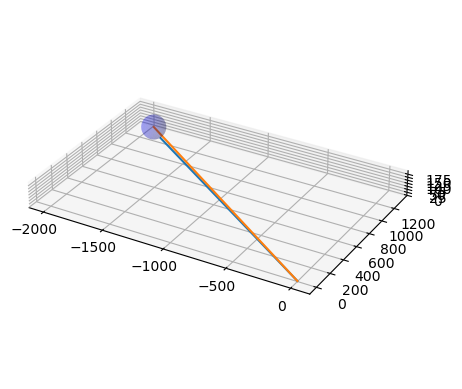

Angle Test: 0


In [100]:
v_idxs = bad_ints['v_idx']
s_idxs = bad_ints['s_idx']

fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")

for v_idx, s_idx in zip(v_idxs, s_idxs):
    # Grab void data
    void_ra, void_de, = voids.loc[v_idx,['RAdeg', 'DEdeg']]
    r_ang_deg, z, v_cmvd, v_r_mpc = voids.loc[v_idx,['r_ang_deg', 'z', 'cmvd_Mpc', 'Reff_Mpc']]
    temp_void_coord = SkyCoord(void_ra * u.deg, void_de *u.deg)



    s_ra, s_de, s_cmvd = work_vhe.loc[s_idx, ['RAdeg', 'DEdeg', 'cmvd_Mpc']]
    singular_vhe_skycoord = SkyCoord(s_ra * u.deg, s_de*u.deg)

    s_v_dist = temp_void_coord.separation(singular_vhe_skycoord)

    bad_counter = 0

    # Passes the angular distance check
    if r_ang_deg < s_v_dist.deg:
        bad_counter += 1

    v_de = void_de
    v_ra = void_ra    
    # Collat
    v_th = 90 - v_de
    s_th = 90 - s_de

    v_th *= (math.pi)/180
    s_th *= (math.pi)/180
    

    
    v_ra *= math.pi/180
    s_ra *= math.pi/180

    rv_cart = cart_comp(v_cmvd, v_th, v_ra)
    rs_cart = cart_comp(s_cmvd, s_th, s_ra)

    # Calculating intersection and intersectoin intervals
    w1_vec = w1(rv_cart, rs_cart)
    # d_vec = rv_cart - w1_vec
    
    # Cv_i = 2 *np.sqrt(v_r_mpc**2 - mag(d_vec)**2)
    little_d = s_v_dist.rad * v_cmvd # Arclength approximation

    ##
    Cv_i = other_voidy_calc(little_d, v_r_mpc) # Cv_i no longer nanny
    ##

    ## Normalization working properly
    w2 = Cv_i/2 * (rs_cart / mag(rs_cart))
    ## 

    T1 = w1_vec - w2

    T2 = T1 + 2 * w2


    n1 = mag(T1)/s_cmvd
    n2 = mag(T2)/s_cmvd

    if n2 > 1:
        n2 = 1

    interval = I.closed(n1, n2)
    if interval.is_empty():
        bad_int = True
    else:
        bad_int = False
    # return I.closed(n1, n2), Cv_i, bad_int
    # ax.plot(np.array([0,0,0]), rs_cart[0], [1], rs_cart[2])
    ax.plot([0, rs_cart[0]],[0, rs_cart[1]],[0, rs_cart[2]])
    ax.plot([0, rv_cart[0]],[0, rv_cart[1]],[0, rv_cart[2]])

    # Void Sphere
    u_sph = np.linspace(0, 2 * np.pi, 100)
    v_sph = np.linspace(0, np.pi, 100)

    x = v_r_mpc * np.outer(np.cos(u_sph), np.sin(v_sph)) + rv_cart[0]
    y = v_r_mpc * np.outer(np.sin(u_sph), np.sin(v_sph)) + rv_cart[1]
    z = v_r_mpc * np.outer(np.ones(np.size(u_sph)), np.cos(v_sph)) + rv_cart[2]

    ax.plot_surface(x, y, z, color='b', alpha=0.2, label='Sphere')
    ax.set_aspect('equal')
    plt.show()
    # break

    

print(f"Angle Test: {bad_counter}")



#### CURRENT METHOD

#### Find overlapping voids

In [101]:
# Depacrated. This will probably wont be needed anymore. Will delete soon
# Create new row to store the GRS's incident void id's
# work_vhe['Assoc_V_IDs'] = np.nan
# work_vhe['Assoc_V_IDs'] =  work_vhe['Assoc_V_IDs'].astype('object') # Cast column to save objects
# for key, _ in vhes.items():
#     cv_voids = vhes[key]
#     v_idx = cv_voids['void_idx']
#     v_ids = list(voids.loc[v_idx, 'ID'].values)
#     work_vhe.at[int(key), 'Assoc_V_IDs'] = v_ids

In [102]:
# Output excel of GRS with the incident voids
filepath = './outputTables/Source_void_coincidences_Table.xlsx'  # Add the .xlsx extension

# Create an Excel writer object
# excel_writer = pd.ExcelWriter(filepath, engine='xlsxwriter')
work_vhe.to_excel(excel_writer=filepath)

In [56]:
overlap_v = {}
for key, dct in vhes.items():
    void_idx = dct['void_idx']
    combos = list(combinations(void_idx, 2))
    for combo in combos:
        v1_idx = combo[0]
        v2_idx = combo[1]
        r1 = voids.loc[v1_idx]['Reff_Mpc']
        r2 = voids.loc[v2_idx]['Reff_Mpc']

        vec1 = get_void_vec(v1_idx, voids)
        vec2 = get_void_vec(v2_idx, voids)
        d = vec1 - vec2
        if mag(d) < (r1 + r2):
        # if True:
            # print(mag(d), r1 + r2)
            overlap_v.setdefault('v_idx', []).append(combo)


        

In [57]:
vhes.keys()

dict_keys([130, 150, 266, 256, 138, 147, 210, 131, 135, 137, 140, 141, 146, 148, 149, 151, 155, 157, 158, 159, 160, 161, 163, 169, 171, 172, 174, 175, 176, 185, 189, 190, 191, 192, 196, 200, 204, 243, 247, 248, 255, 121, 246, 118, 250, 195, 197, 198, 206, 207, 216, 223, 225, 229, 230, 236, 237, 111, 112, 120, 122, 220, 221, 254, 179, 182, 268, 154, 110, 271, 242, 245, 166, 238, 244, 124, 105, 142, 114, 213, 240, 260, 106, 231, 123, 101, 133, 226, 233, 227, 263, 235, 113, 274, 117])

In [58]:
work_vhe

,OG_idx,Source_Name,RAdeg,DEdeg,z,TEVCAT_FLAG,Spectral_Index,Unc_Spectral_Index,Flux,Unc_Flux,...,Unc_Flux_Band_1_b,Unc_Flux_Band_2_a,Unc_Flux_Band_2_b,Unc_Flux_Band_3_a,Unc_Flux_Band_3_b,Unc_Flux_Band_4_a,Unc_Flux_Band_4_b,cmvd_Mpc,RAdeg_gal,DEdeg_gal
101,101,b'3FHL J0754.8+4822 ',118.709427,48.381851,0.37671,b'N',1.844553,0.477081,6.366334e-11,1.414227e-11,...,9.273509e-12,NaN,5.174297e-12,NaN,4.356179e-12,NaN,4.641887e-12,1489.985058,170.569883,30.154120
105,105,b'3FHL J0809.7+3457 ',122.429825,34.958000,0.08300,b'C',1.537894,0.398432,3.762599e-11,1.178684e-11,...,8.085367e-12,-3.622594e-12,5.682121e-12,-2.196309e-12,4.270880e-12,NaN,5.413912e-12,352.435772,186.447142,30.370766
106,106,b'3FHL J0809.8+5218 ',122.458603,52.310394,0.13800,b'P',2.085875,0.150503,5.031846e-10,3.784231e-11,...,2.006459e-11,-1.311989e-11,1.522318e-11,-4.510572e-12,6.316802e-12,NaN,4.493836e-12,578.617295,166.252082,32.912325
110,110,b'3FHL J0816.9+2050 ',124.236435,20.847292,0.05800,b'N',1.687501,0.694033,3.335314e-11,1.233066e-11,...,9.271541e-12,-2.308233e-12,4.485689e-12,NaN,5.143181e-12,NaN,6.364596e-12,247.668418,202.424760,27.738667
111,111,b'3FHL J0818.2+4222 ',124.562164,42.376682,0.53000,b'N',2.579031,0.410084,2.336202e-10,2.770750e-11,...,1.566809e-11,-2.063953e-12,4.012071e-12,NaN,4.484594e-12,NaN,4.872048e-12,2015.283912,178.230310,33.398329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,266,b'3FHL J1607.0+1550 ',241.756088,15.835721,0.49600,b'N',3.177758,0.790509,6.020107e-11,1.460740e-11,...,8.727400e-12,-2.044046e-12,4.266526e-12,NaN,4.624338e-12,NaN,5.071932e-12,1902.710656,29.337635,43.418285
268,268,b'3FHL J1626.2+3515 ',246.574768,35.262291,0.49738,b'N',1.318621,0.691001,2.254689e-11,9.101243e-12,...,8.785571e-12,-2.051363e-12,3.925008e-12,NaN,4.401563e-12,NaN,4.984420e-12,1907.322882,56.963032,43.892147
271,271,b'3FHL J1642.9+3948 ',250.734909,39.814907,0.59300,b'N',1.905996,0.506023,6.053068e-11,1.508011e-11,...,1.019531e-11,-3.750062e-12,5.456328e-12,NaN,5.645884e-12,NaN,4.868356e-12,2218.105586,63.460492,40.956902
274,274,b'3FHL J1652.7+4024 ',253.194107,40.403389,0.24000,b'N',1.596837,0.748321,3.324196e-11,1.183103e-11,...,9.128316e-12,NaN,5.811772e-12,NaN,5.890670e-12,NaN,4.813395e-12,982.107172,64.401557,39.122618


In [59]:
# TODO: Instead of saving into a seperate dictionary just save it as an additional
# entry in vhes dictionary

voidiness = {}
TEV_voidiness = {}
over1_idx= []
src_keys = list(vhes.keys())
TEV_src_idx = []
flags = ["b'P'","b'E'", "b'C'"] # TODO: check the flag
# flags = ["b'P'","b'E'"]
# There are 4 Flags, P, E, N, C
# What happens if we include C, the candidates?
for idx in list(work_vhe.index):
    # print(type(idx))
    if idx in src_keys:
        # total_d = work_vhe.loc[int(idx)]['cmvd_Mpc']
        # Cvs = vhes[idx]['Cv']
        # # if len(Cvs) > 2:
        # #     print(Cvs,'\n')
        # voidiness_i = sum(Cvs)/total_d

        # Interval based voidiness calculation
        ints = vhes[idx]['intervals']
        union = take_union(ints)
        voidiness_i = calc_voidiness(union)
        vhes[idx]["Voidiness"] = voidiness_i

        # GRS specific code
        # Add TEV flags to VHES dictionary
        if str(work_vhe.loc[idx, 'TEVCAT_FLAG']) in flags:
            vhes[idx]['TEV_Flag'] = True
        else:
            vhes[idx]['TEV_Flag'] = False

    else:
        voidiness_i = 0
    # break
    voidiness[idx] = voidiness_i
    
    ## GRS specific code
    if str(work_vhe.loc[idx, 'TEVCAT_FLAG']) in flags:
        TEV_voidiness[idx] = voidiness_i


# Export work_vhe table to excel
export = False # under an "if" so that it doesnt do it each time it runs
if export:
    select_columns = ['Source_Name', 'RAdeg', 'DEdeg', 'z', 'TEVCAT_FLAG']
    work_vhe[select_columns].to_excel('SDSS_filtered_FHL_GRS.xlsx', index=False)

### Voidiness Histogram

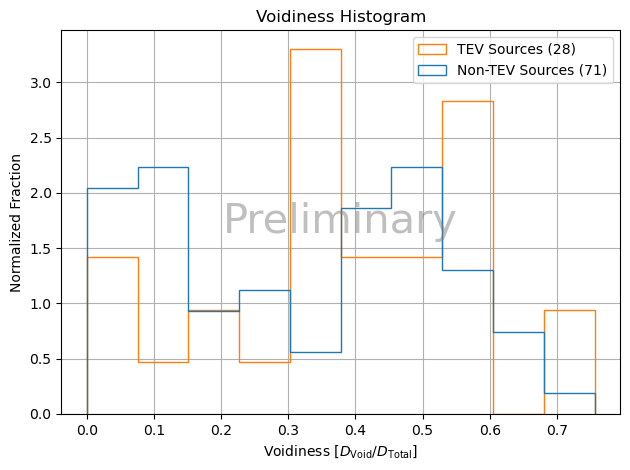

In [60]:

l_all = len(voidiness)
l_TEV = len(TEV_voidiness)

voidiness_list = [item for _, item in voidiness.items()]
TEV_voidiness_list = [item for _, item in TEV_voidiness.items()]

TEV_idx =  TEV_voidiness.keys()
all_idx = voidiness.keys()

non_TEV_list = []
for idx in all_idx:
    if idx not in TEV_idx:
        non_TEV_list.append(voidiness[idx])
l_non_tev = len(non_TEV_list)






# This one plots with ALL
# plot_hist_watermark([non_TEV_list, TEV_voidiness_list, voidiness_list], bins=20,
#           xlabel='Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]',
#           ylabel='Normalized Fraction',
#           title='Voidiness Histogram',
#           watermark_text='Preliminary',
#           label=[f'Non-TEV Sources ({l_non_tev})', f'TEV Sources ({l_TEV})',f'All Sources ({l_all})'],
#           density=True)

# This one does NOT plot with ALL
plot_hist_watermark([non_TEV_list, TEV_voidiness_list], bins=10,
          xlabel='Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]',
          ylabel='Normalized Fraction',
          title='Voidiness Histogram',
          watermark_text='Preliminary',
          label=[f'Non-TEV Sources ({l_non_tev})', f'TEV Sources ({l_TEV})'],
          density=True)
# ax.text(0.5, 0.5, 'created with matplotlib', transform=ax.transAxes,
#         fontsize=40, color='gray', alpha=0.5,
        # ha='center', va='center', rotation=30)

voidiness  vs spectral index
voidiness vs. integral flux

Redo Void coincidence with sdss galaxies



In [61]:
# Number of all sources didn't change when I included the candidate sources.
# TEV sources go up. from 19 to 41

In [62]:
# Number of all sources didn't change when I included the candidate sources.
# TEV sources go up. from 19 to 41

### Voidiness Line Plots

In [63]:
# Testing logic to splice up Large list into smaller list and handling the 
# remaining elements~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sub_len = 10
l = range(0,101)
n_full_rows = len(l)//sub_len
rem = len(l)%sub_len

new_l = []
for i in range(n_full_rows):
    new_l.append(l[0+sub_len*i:sub_len*(i+1)])

if rem:
    new_l.append(l[-rem:])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

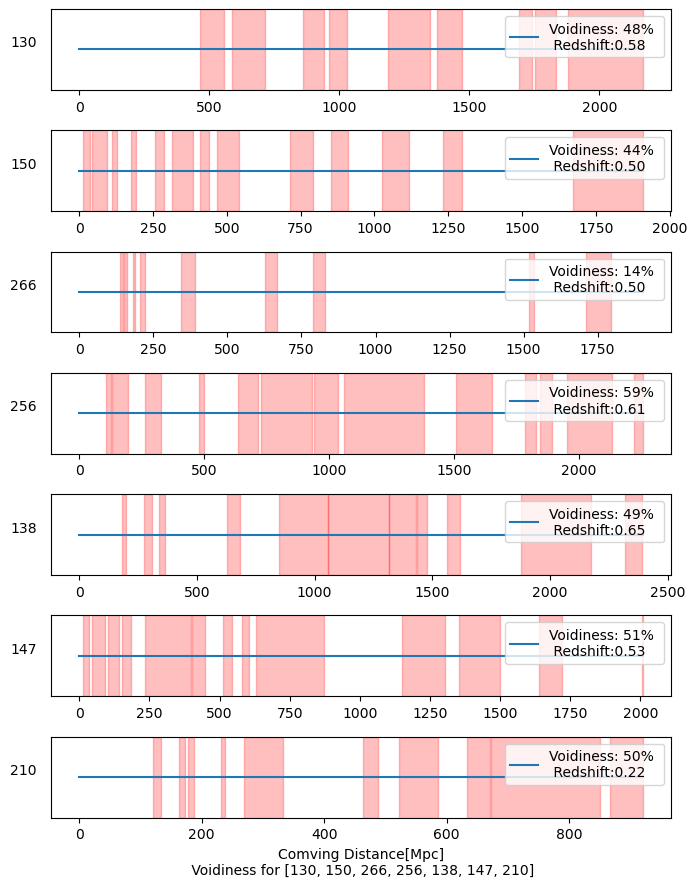

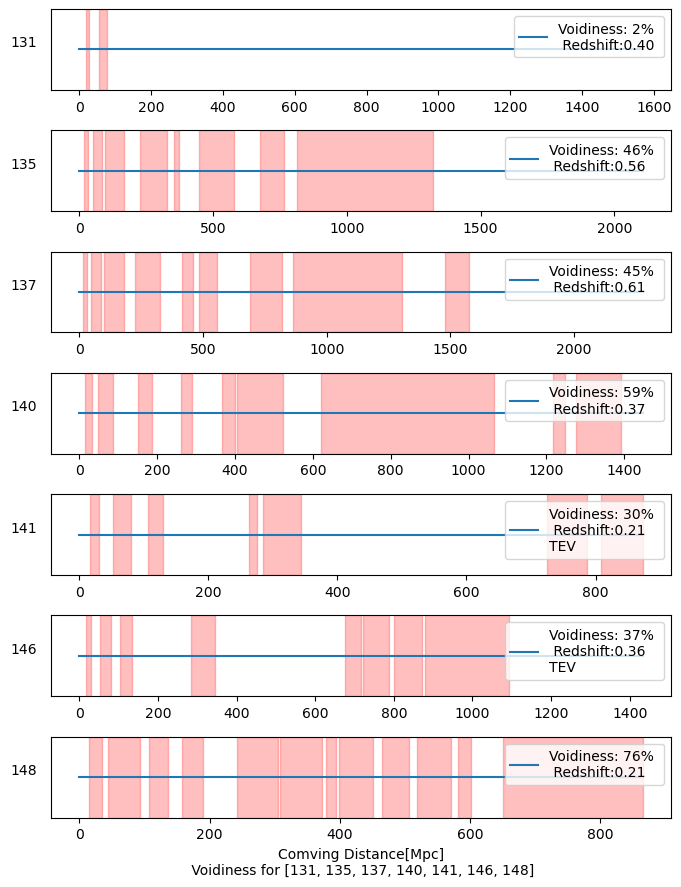

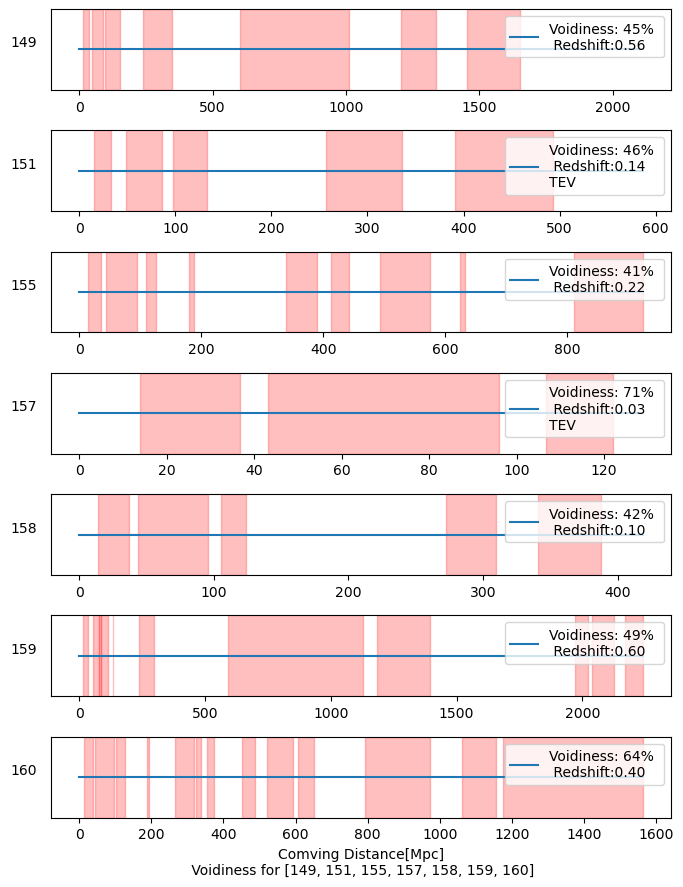

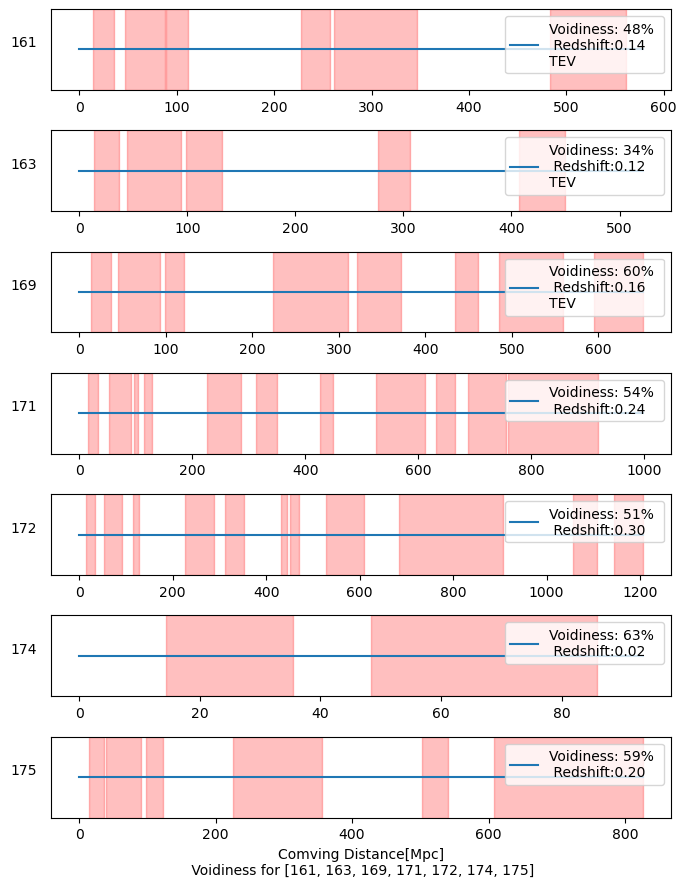

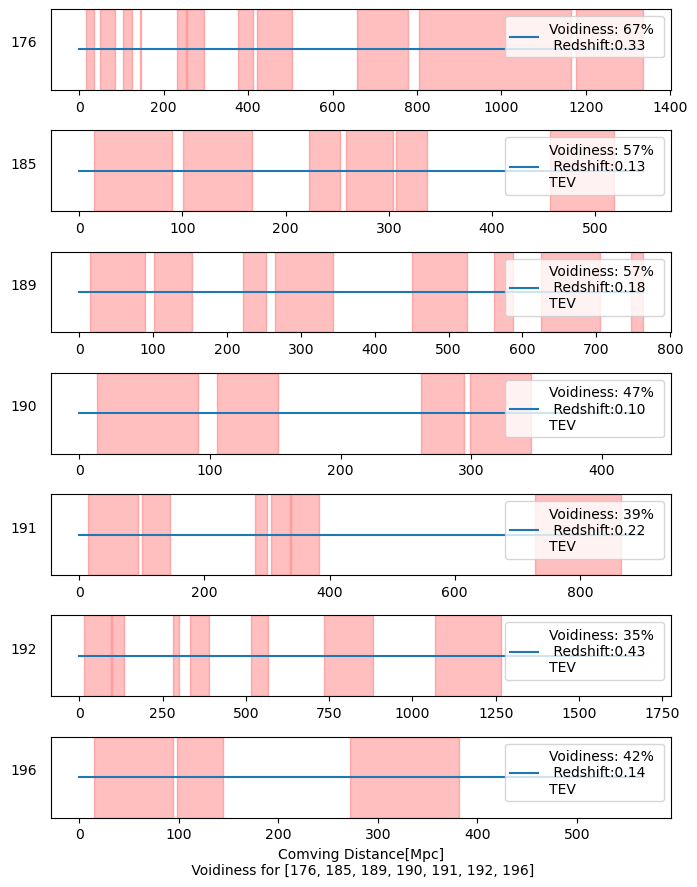

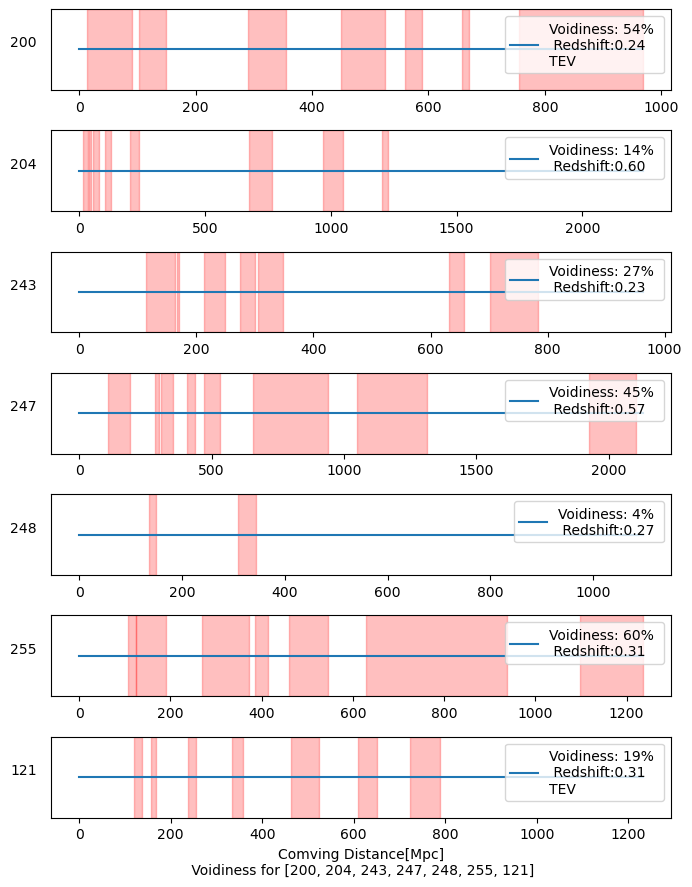

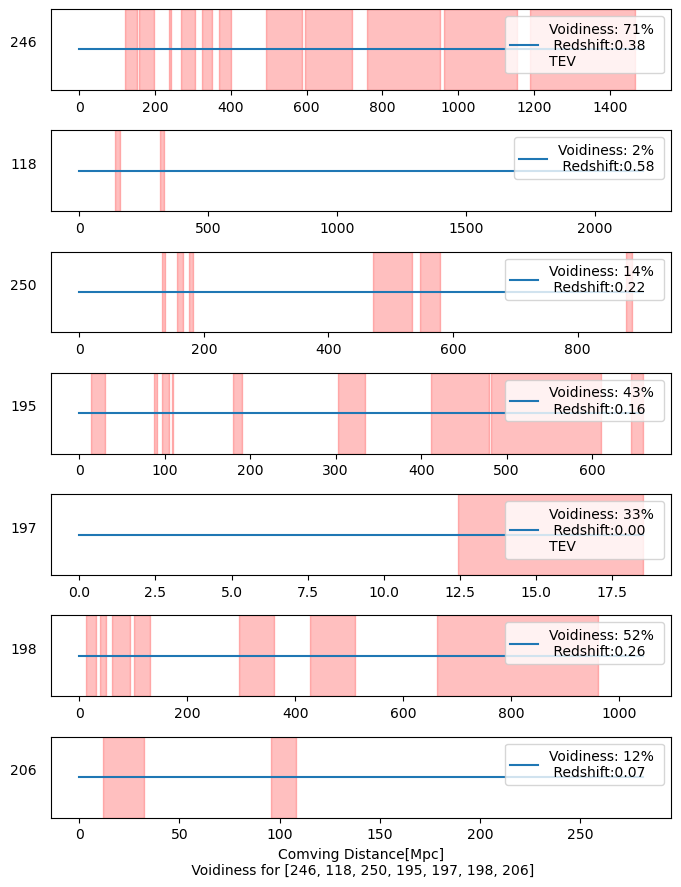

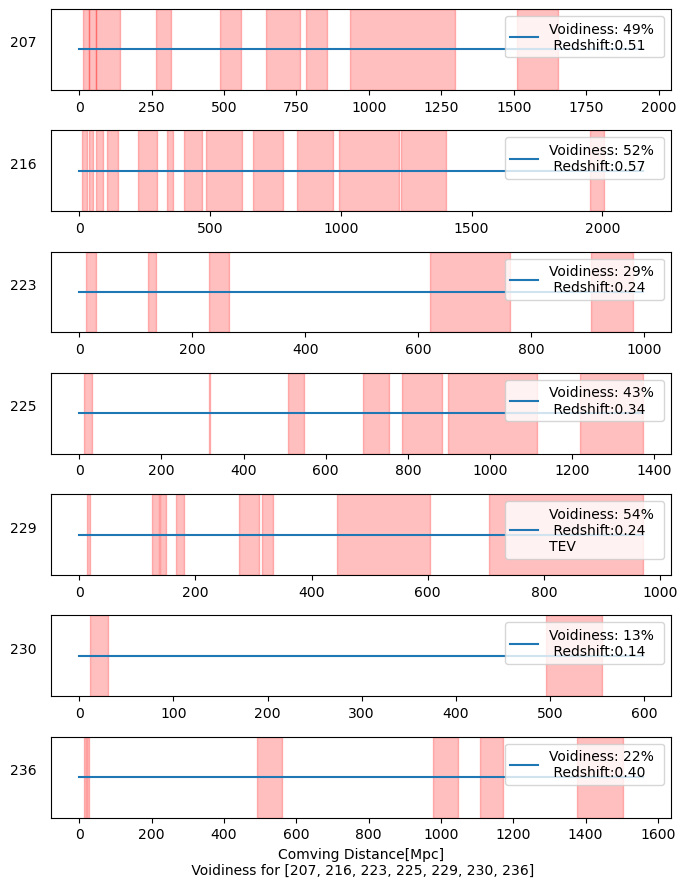

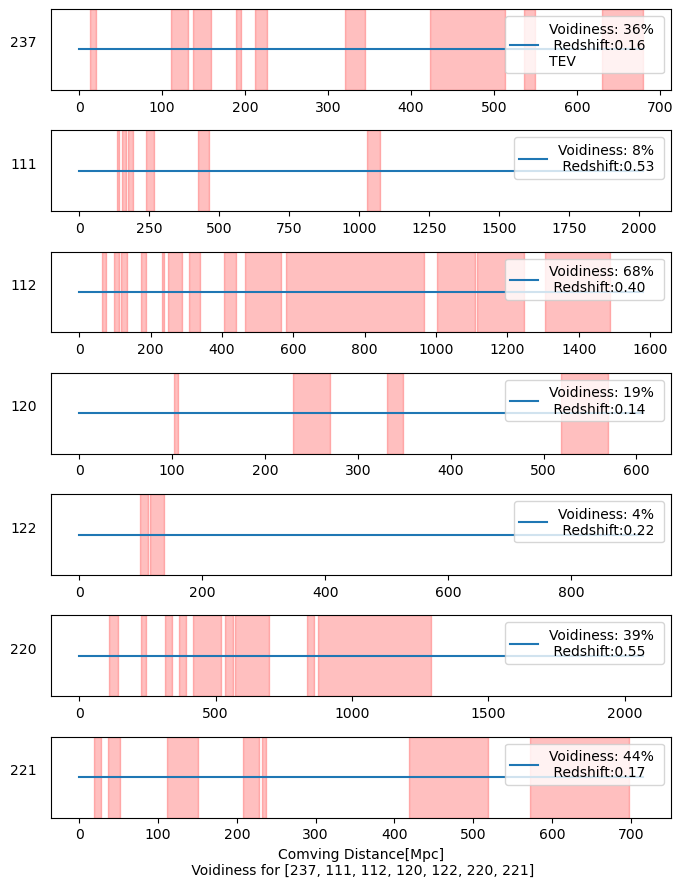

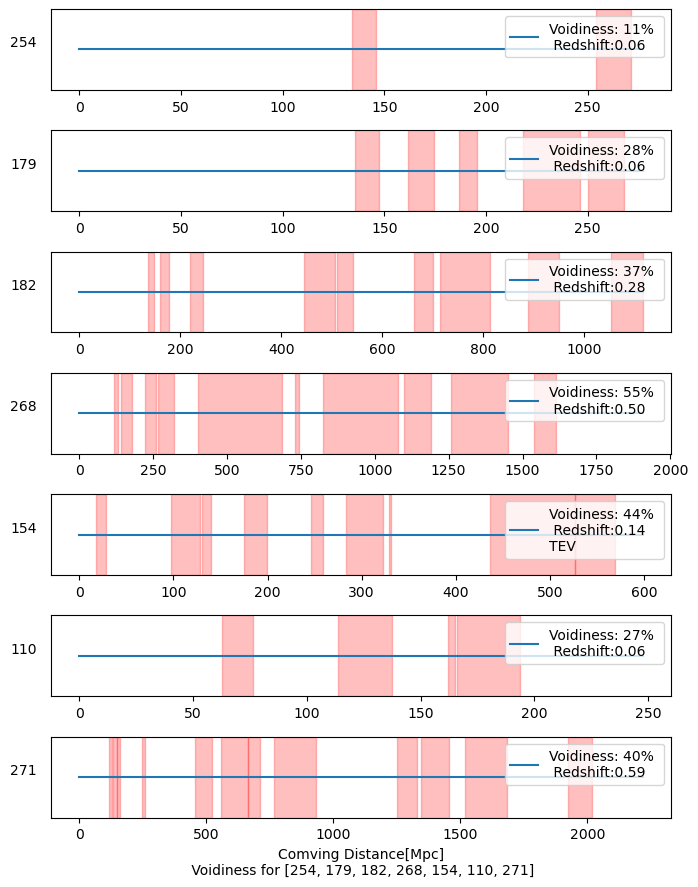

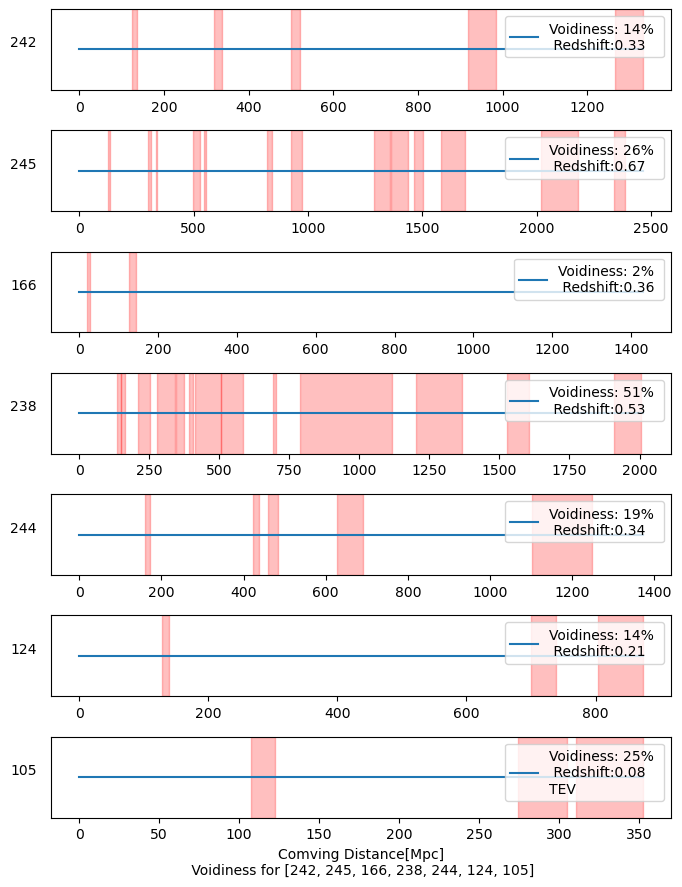

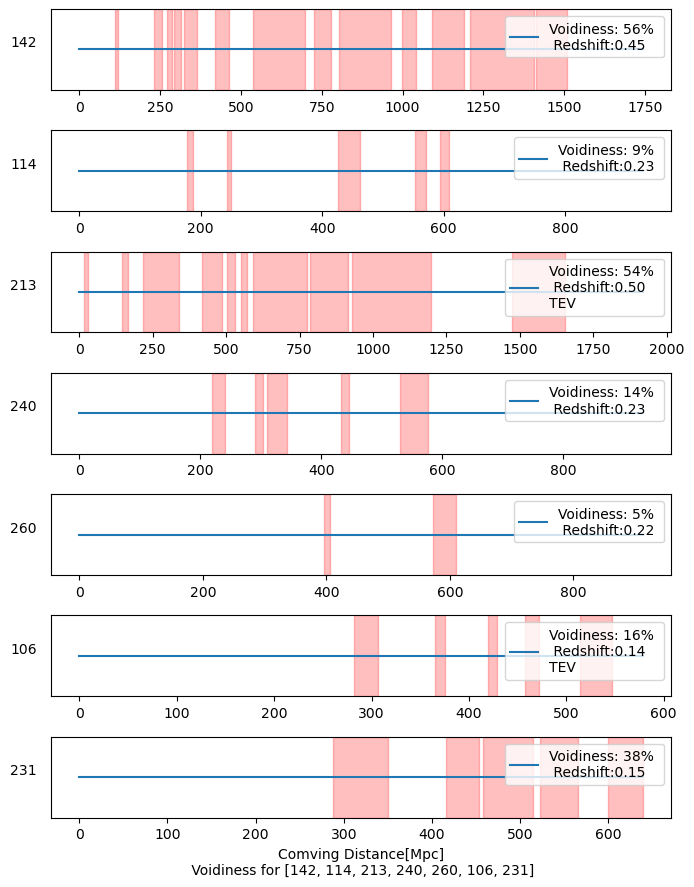

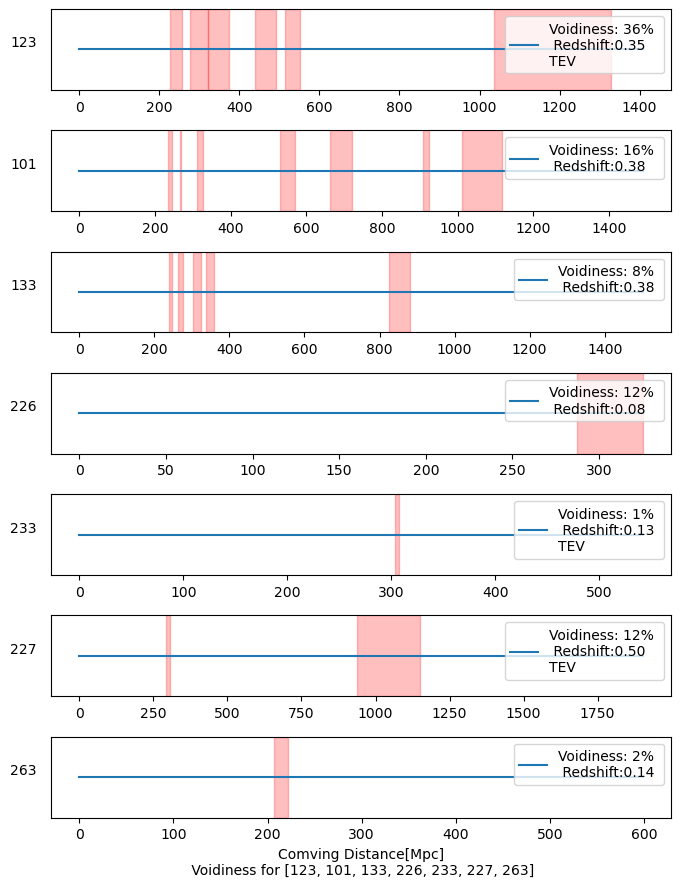

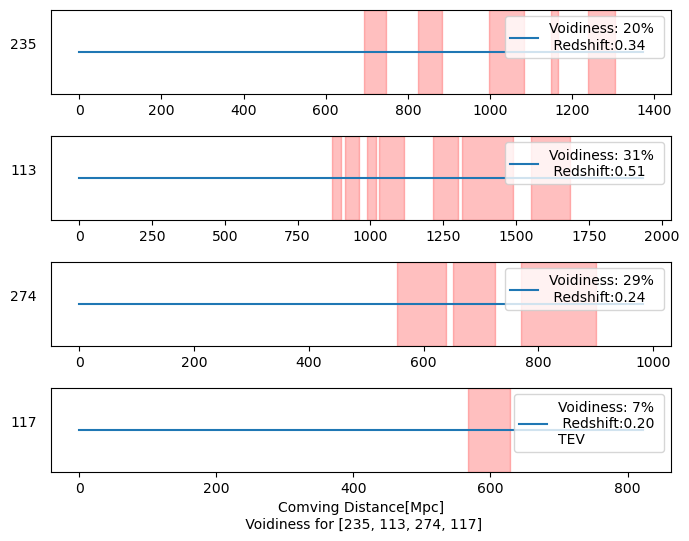

In [64]:
# Declaring some initial variables
num_r = 7 # Number of rows per subplot
width = 8 # inches. 
dr = "./output_plots/Voidiness_line_plots/" # Directory to save plots

# Chop up large list of GRS indices into sublists~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
n_full_rows  = len(src_keys)//num_r # Number of full rows without empty gaps
rem = len(src_keys)%num_r # Remainder 

chopped_keys = []
for i in range(n_full_rows):
    # Grab i'th group of num_r src keys
    chopped_keys.append(src_keys[0+num_r*i:num_r*(i+1)])

if rem:
    chopped_keys.append(src_keys[-rem:])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Batch count number and save plots
batch_no = 1
total_batches = len(chopped_keys)
for sub_list in chopped_keys:
    sub_len = len(sub_list)

    fig, axs = plt.subplots(nrows=sub_len, figsize=(width, sub_len*1.5))

    for grs, ax in zip(sub_list, axs.flat):
        

        voidiness_i = voidiness[grs] # Voidiness percent

        cmvd_i = work_vhe.loc[grs, 'cmvd_Mpc'] # Comoving distance to GRS
        z_i = work_vhe.loc[grs, 'z']

        v_id = vhes[grs]['void_idx'] # Incident void Ids with current GRS

        # Create ranges of voidiness to show on plot~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # This is with approximation.
        v_cmvd_mpc = voids.loc[v_id, 'cmvd_Mpc'].values
        v_r_mpc = voids.loc[v_id, 'Reff_Mpc'].values

        v_r_mpc *= (4/3) /2

        void_ranges = []
        void_intervals = vhes[grs]['intervals']
        union = take_union(void_intervals)
        # for o, r in zip(v_cmvd_mpc, v_r_mpc): # This produces the old line graphs that overlap
        #     void_ranges.append((o-r, o+r))

        # Now we are actually using the union method
        for v_int in union:
            # v_int.low
            if np.issubdtype(type(v_int.lower), float): # protects against empty intervals
                low = v_int.lower * cmvd_i
                hi = v_int.upper * cmvd_i
                void_ranges.append((low, hi))



        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        # I will now use the actual interval

        ax.plot([0,cmvd_i],[1,1])
        ax.set_ylabel(grs, rotation=0, labelpad=20)
        ax.set_yticks([])
        # ax.set_xlabel("Comoving Distance [Mpc]")
        # Add TEV Flag
        if vhes[grs]["TEV_Flag"]:
            tev_flag = "\nTEV"
        else:
            tev_flag = ""
        
        ax.legend([f"Voidiness: {voidiness_i*100:.0f}% \n Redshift:{z_i:.2f}"  + tev_flag], loc="upper right")

        # Color in voidy regions
        for start, end in void_ranges:
            ax.axvspan(start, end, color='red', alpha=0.25)

    # plt.title(f"Voidiness for{sub_list}")
    plt.xlabel(f"Comving Distance[Mpc]\n Voidiness for {sub_list}")

    plt.subplots_adjust(hspace=0.5)
    
 
    plt.savefig(dr + "Using_intervals" + f"Batch_no_{batch_no}_of_{total_batches}.jpg")
    batch_no += 1



### Plotting voidiness vs Spectral inex and Flux

In [65]:
grsources = list(vhes.keys())
TEVs = []

# TEVs = grsources[vhes[grsources]["TEV_Flag"]]
for g in grsources:
    if vhes[g]["TEV_Flag"]:
        TEVs.append(g)


nonTEVs = [item for item in grsources if item != TEVs]



SPEC_index = work_vhe.loc[nonTEVs, "Spectral_Index"].values
SPEC_uncert = work_vhe.loc[nonTEVs, "Unc_Spectral_Index"].values

# Flux = work_vhe.loc[grsources, "Flux"].values
# Flux_uncert = work_vhe.loc[grsources, "Unc_Flux"].values




Text(0, 0.5, 'Spectral Index')

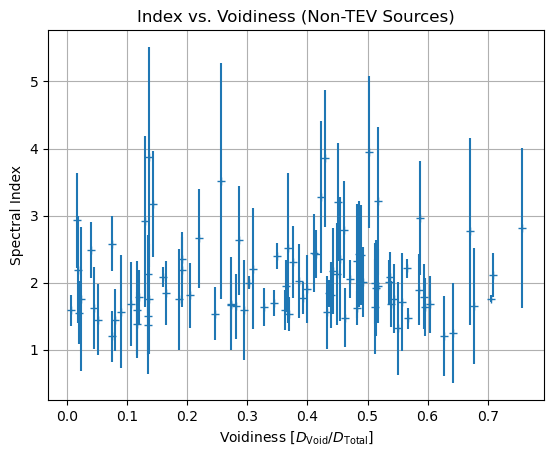

In [66]:
# Plots with bins
SPEC_index = work_vhe.loc[nonTEVs, "Spectral_Index"].values
SPEC_uncert = work_vhe.loc[nonTEVs, "Unc_Spectral_Index"].values

# Flux = work_vhe.loc[grsources, "Flux"].values
# Flux_uncert = work_vhe.loc[grsources, "Unc_Flux"].values

voidis= []
for grs in nonTEVs:
    voidis.append(vhes[grs]["Voidiness"])

plt.errorbar(voidis, SPEC_index, yerr=SPEC_uncert, linestyle='', marker = "+")
plt.grid()
plt.title("Index vs. Voidiness (Non-TEV Sources)")
plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
plt.ylabel("Spectral Index")
# plt.savefig("./output_plots/nsf_proposal/Index_Voidiness_(Non-TEV_Sources).PS")



In [67]:
# Consolidate the uncertainties to be consistent. 1 value for each data point.
# The asymmetric flux are made symmetric by calcualting the mid points. 
# The actual flux data point is plotted seperately. 

flux_bands = work_vhe.loc[nonTEVs, col_names_flux].values
unc_flux = work_vhe.loc[nonTEVs, col_names_unc]

faux_unc = np.zeros((5, len(unc_flux)))
faux_flux = np.zeros((5, len(unc_flux)))
for i in range(5):
    for j in range(len(unc_flux)):
        temp_unc = unc_flux.iloc[j, 0+i*2:2+i*2] # grabbing groups of two
        has_nan = any(np.isnan(x) for x in temp_unc)
        if has_nan: # Single value uncertainty
            num = [x for x in temp_unc if not np.isnan(x)][0] #[0] grabs the one value without putting it in a list
            faux_unc[i, j] = num
            faux_flux[i, j] = flux_bands[j, i]
        else: # Does not have nans, asymmetric uncertainty.
            actual_flux = flux_bands[j, i]
            uncerts = actual_flux + temp_unc
            faux_flux[i, j] = np.mean(uncerts) # calculate centroid of uncerts
            faux_unc[i, j]  = max(uncerts) - faux_flux[i, j]




In [68]:
chi2_log = np.zeros((5,1,2))
chi2_log[1, 0, : ] = [1, 1]
chi2_log[1]

array([[1., 1.]])

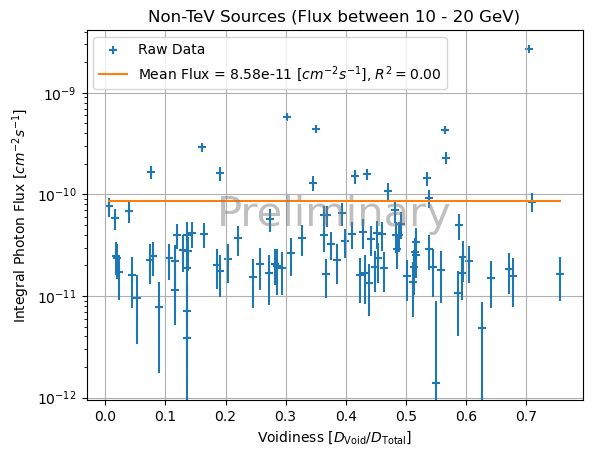

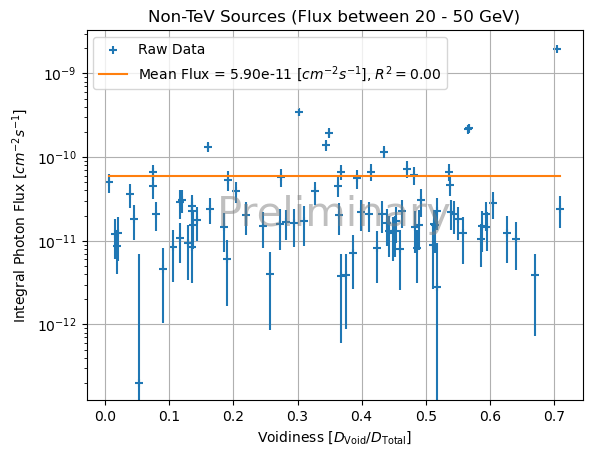

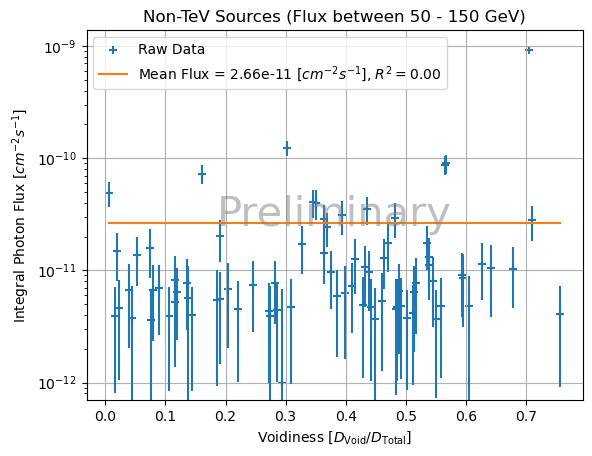

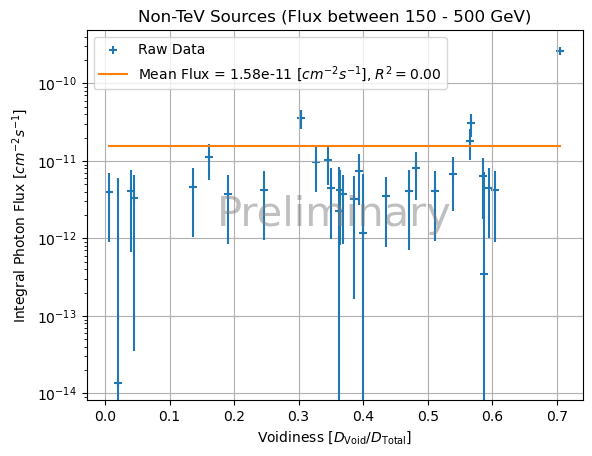

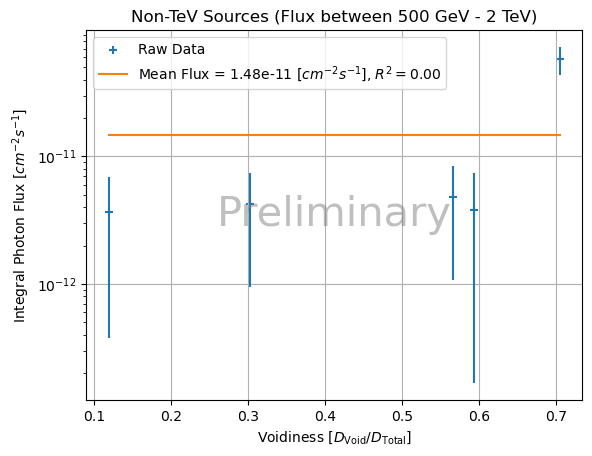

In [69]:
# Exclude TEVS in this one
bands = ["10 - 20 GeV",
         "20 - 50 GeV",
         "50 - 150 GeV",
         "150 - 500 GeV",
         "500 GeV - 2 TeV"]

fn_bands = ["10_20",
         "20_50",
         "50_150",
         "150_500",
         "500_2_TeV"]
def linear_model(x, a, b):
    return a * x + b

# Perform the curve fit
# popt, pcov = curve_fit(linear_model, voidis, SPEC_index, sigma=SPEC_uncert)
# slope, intercept = popt
# fit_line_w_err = linear_model(np.array(voidis), slope, intercept)

# plt.plot(voidis, fit_line_w_err, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}')


# empty lists to save the chi^2 values 
# First index is for fit second is for average
chi2_log = np.zeros((5,1,3))
chi2_nolog = np.zeros((5,1,3))
for i in range(5):
    # For non TEV sources we remove sources with a large error bar
    mask = faux_flux[i, :] > 1e-14

    temp_flux = faux_flux[i, mask]
    temp_unc = faux_unc[i,mask]
    temp_voidis = np.array(voidis)[mask]
    plt.figure()
    # plt.errorbar(voidis, faux_flux[i, :], yerr=faux_unc[i,:], linestyle='', label="Raw Data")
    # plt.errorbar(voidis, temp_flux, yerr=temp_unc, linestyle='', label="Raw Data")
    plt.errorbar(temp_voidis, temp_flux, yerr=temp_unc, linestyle='')


    plt.yscale('log')
    # plt.scatter(voidis, flux_bands[:, i], marker='+')
    plt.scatter(temp_voidis, temp_flux, marker='+', label="Raw Data")
    plt.grid()
    title = f"Non-TeV Sources (Flux between {bands[i]})"
    plt.title(title)
    plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
    plt.ylabel("Integral Photon Flux [$cm^{-2} s^{-1}$] ")


    # Chi^2 stuff

    avg = np.mean(temp_flux)

    avg_line = avg * np.ones_like(temp_voidis)
    # plotted later

    try:
        # # Line fit
        # Note. the true lin-lin (x-y) values of voidiness and flux are given to plt. 
        # but its plotted in lin-log10 space. we fit the curve to lin-log10 space
        # Then plot the lin-lin values by raising the fitted curve to np.exp
        popt, pcov = curve_fit(linear_model, temp_voidis,  temp_flux, sigma=temp_unc)
        # popt, pcov = curve_fit(linear_model, temp_voidis,  np.log10(temp_flux), sigma=np.log10(temp_unc))
        slope, intercept = popt
        fit_line_w_err = linear_model(np.array(temp_voidis), slope, intercept)

        chi2_fit_nolog = (np.sum((temp_flux - fit_line_w_err)**2/(fit_line_w_err)))/(len(temp_flux) - 1)
        # chi2_fit_log = (np.sum((np.log10(temp_flux) - np.exp(fit_line_w_err))**2/np.exp(fit_line_w_err)))/(len(temp_flux) - 1)

        p_fit = chi2.sf(chi2_fit_nolog, len(temp_flux) - 1)


        chi2_avg_nolog = (np.sum((temp_flux - (avg))**2)/(avg))/(len(temp_flux) - 1)
        p_avg = chi2.sf(chi2_avg_nolog, len(temp_flux) - 1)
        # chi2_avg_log = (np.sum((np.log10(temp_flux) - avg)**2)/avg)/(len(temp_flux) - 1)

        # difflog = chi2_fit_log - chi2_avg_log
        diffnolog = chi2_fit_nolog - chi2_avg_nolog

        # chi2_log[i, 0, :] = [chi2_fit_log, chi2_avg_log, difflog]
        chi2_nolog[i, 0, :] = [chi2_fit_nolog, chi2_avg_nolog, diffnolog]
        

        r2_fit = r2_score(temp_flux, fit_line_w_err)
        r2_avg = r2_score(temp_flux, avg_line)

        # print(len(temp_flux)- 1)


        # using scipt to calcualte q-squared and its significant

        # chi2_fit_scipy, p_fit = chisquare(temp_flux, 10**fit_line_w_err, ddof=len(temp_flux)-1)
        # chi2_avg_scipt, p_avg = chisquare(temp_flux, avg_line, ddof=len(temp_flux)-1)

        # Ordering the data points to get 
        ordered_idx = np.argsort(temp_voidis)
        ord_voidis = temp_voidis[ordered_idx]
        ord_fit = fit_line_w_err[ordered_idx]

        # $R^2 =${r2_fit:.2f},
        #  $\Delta\chi^2=${diffnolog:.2e},
        # Not plotting the fit lines for AAS
        # plt.plot(ord_voidis, ord_fit, label=f'Fit Line, $\chi^2=$ {chi2_fit_nolog:.2e}, p = {p_fit:.2f}')
        # plt.plot(temp_voidis, np.exp(fit_line_w_err), label=f'Fit Line: y = {slope:.2e}x + {intercept:.2e} X^2_l = {chi2_fit_log:.2e} X^2_nl = {chi2_fit_nolog:.2e}')


    except:
        print("error")
        if i==3:
            # NOTE: inf and Nans pop up when trying to fit a curve on the 4th plot. 
            # No other known errors. This should be investigated.
            continue


    ordered_idx = np.argsort(temp_voidis)
    ord_voidis = temp_voidis[ordered_idx]
    ord_avg = avg_line[ordered_idx]

    # $R^2 =${r2_avg:.2f},
    # $\chi^2 = {chi2_avg_nolog:0.2e}$, p = {p_avg:.2f}
    plt.plot(ord_voidis, ord_avg, label=f"Mean Flux = {avg:.2e} [$cm^{{-2}} s^{{-1}}$], $R^2 =${r2_avg:.2f}")
    # plt.plot(temp_voidis, avg_line, label=f"Mean Flux {avg:.2e}, X^2_l = {chi2_avg_log:.2e} X^2_nl = {chi2_avg_nolog:.2e}")

    plt.text(0.5, 0.5, "Preliminary",  # Adjust the position as needed
                 fontsize=30, color='gray', alpha=0.5,
                 ha='center', va='center', transform=plt.gca().transAxes)

    plt.legend(loc = "upper left")
    dirs = "./output_plots/nsf_proposal/"
    fn = "Integral_Photon_Flux_between_" + fn_bands[i] + "_(Non-TEV_Sources)_vs_Voidiness.PS"
    # plt.savefig(dirs + fn)

# Line fit separate for TEV
# Fit line to integral flux ones 
# See if slope is conisistent with 0
    
# dof = #data points - 1
    
# fitting no slope and reducec x^2 close to 1, the dependant parameter (int flux) shows no variance as voidiness changes
# no dependance


Difference calculated as $\Chi^2_{fit} - \Chi^2_{avg}$.

In [70]:
np.shape(temp_flux)

(5,)

In [71]:
# chi2_fit_scipy, p_fit = chisquare(temp_flux, 10**log_fit_line_w_err, ddof=len(temp_flux)-1)

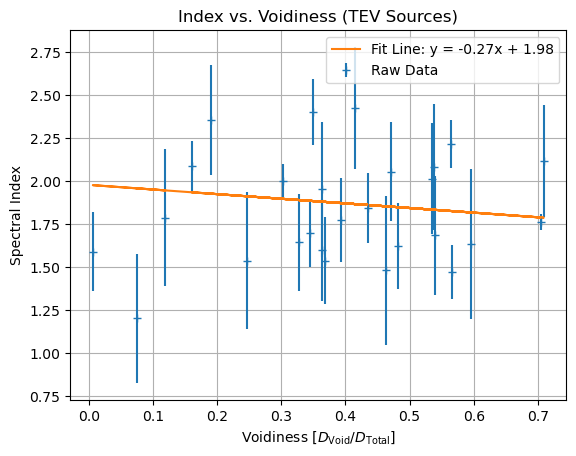

In [72]:
# Plots with bins
SPEC_index = work_vhe.loc[TEVs, "Spectral_Index"].values
SPEC_uncert = work_vhe.loc[TEVs, "Unc_Spectral_Index"].values

# Flux = work_vhe.loc[TEVs, "Flux"].values
# Flux_uncert = work_vhe.loc[TEVs, "Unc_Flux"].values

voidis= []
for grs in TEVs:
    voidis.append(vhes[grs]["Voidiness"])

plt.errorbar(voidis, SPEC_index, yerr=SPEC_uncert, linestyle='', marker = "+", label="Raw Data")
plt.grid()
plt.title("Index vs. Voidiness (TEV Sources)")
plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
plt.ylabel("Spectral Index")

# Curve fit
# Define your linear model
def linear_model(x, m, b):
    return m * x + b

# Perform the curve fit
popt, pcov = curve_fit(linear_model, voidis, SPEC_index, sigma=SPEC_uncert)

# Extract the optimal values for a (slope) and b (intercept)
slope, intercept = popt

# Calculate the best fit line
fit_line_w_err = linear_model(np.array(voidis), slope, intercept)

plt.plot(voidis, fit_line_w_err, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}')

# Perform the curve fit
# popt, pcov = curve_fit(linear_model, voidis, SPEC_index)

# # Extract the optimal values for a (slope) and b (intercept)
# slope, intercept = popt

# Calculate the best fit line
# fit_line_wo_err = linear_model(np.array(voidis), slope, intercept)

# plt.plot(voidis, fit_line_wo_err, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}')


plt.legend()

dirs = "./output_plots/nsf_proposal/"
fn = "Spectral_TEV_vs_Voidiness.PS"
# plt.savefig(dirs + fn)

# plt.figure()
# plt.title("Flux vs. Voidiness TEVs")
# plt.xlabel("Voidiness")
# plt.ylabel("Flux")
# plt.errorbar(voidis, Flux, yerr=Flux_uncert, linestyle='', marker="+")
# plt.grid()

In [73]:
type(voidis)

list

In [74]:
# Consolidate the uncertainties to be consistent. 1 value for each data point.
# The asymmetric flux are made symmetric by calcualting the mid points. 
# The actual flux data point is plotted seperately. 

flux_bands = work_vhe.loc[TEVs, col_names_flux].values
unc_flux = work_vhe.loc[TEVs, col_names_unc]
voidis= []
for grs in TEVs:
    voidis.append(vhes[grs]["Voidiness"])
    
faux_unc = np.zeros((5, len(unc_flux)))
faux_flux = np.zeros((5, len(unc_flux)))
for i in range(5):
    for j in range(len(unc_flux)):
        temp_unc = unc_flux.iloc[j, 0+i*2:2+i*2]
        has_nan = any(np.isnan(x) for x in temp_unc)
        if has_nan: # Single value uncertainty
            num = [x for x in temp_unc if not np.isnan(x)][0] #[0] grabs the one value without putting it in a list
            faux_unc[i, j] = num
            faux_flux[i, j] = flux_bands[j, i]
        else: # Does not have nans, asymmetric uncertainty.
            actual_flux = flux_bands[j, i]
            uncerts = actual_flux + temp_unc
            faux_flux[i, j] = np.mean(uncerts) # calculate centroid of uncerts
            faux_unc[i, j]  = max(uncerts) - faux_flux[i, j]




In [75]:
TEVs[9]

190

In [76]:
vvv = flux_bands[:,0]

2.990881521895939e-08
2.3552443977391973e-08
1.1876142072727732e-08
4.094884526806151e-09
1.2307404343693151e-09


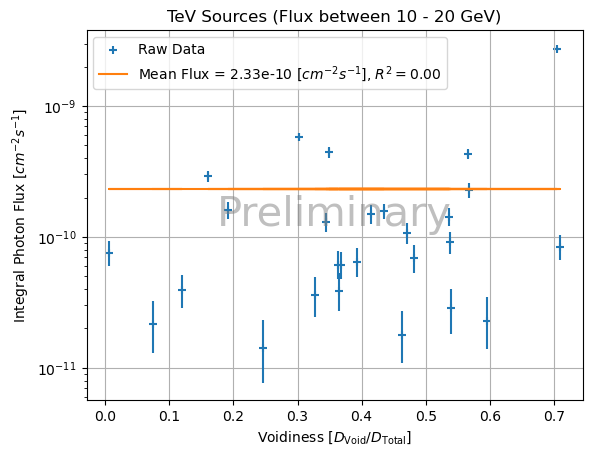

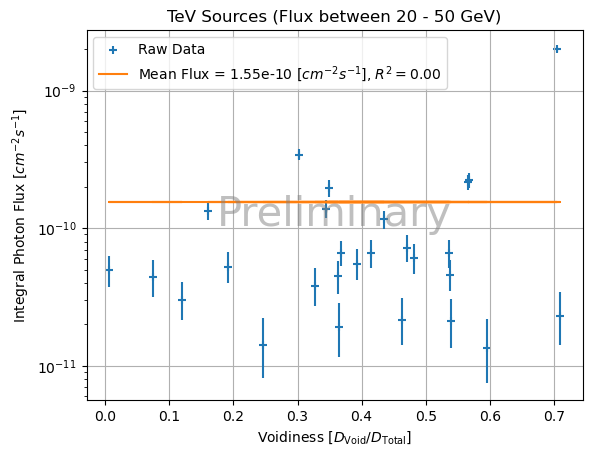

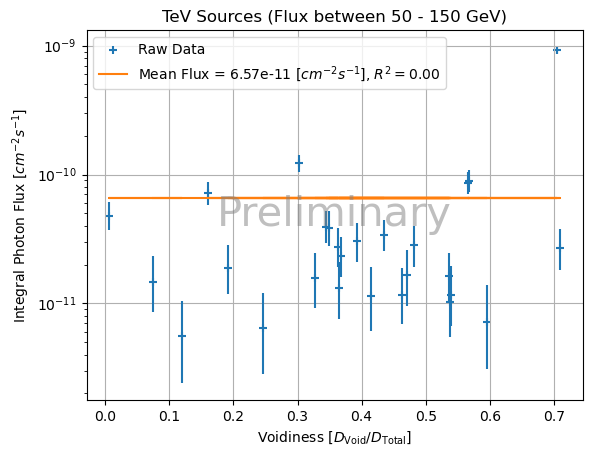

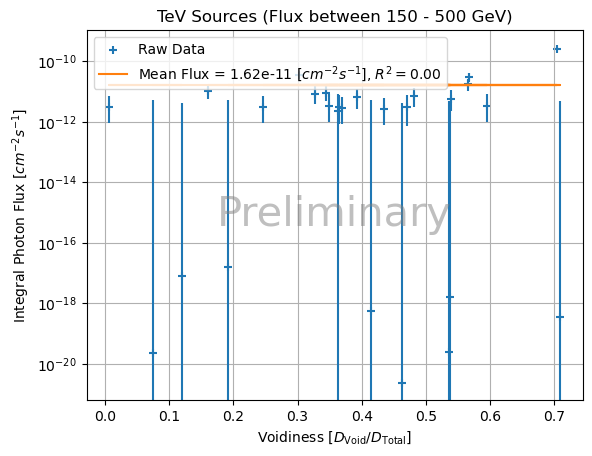

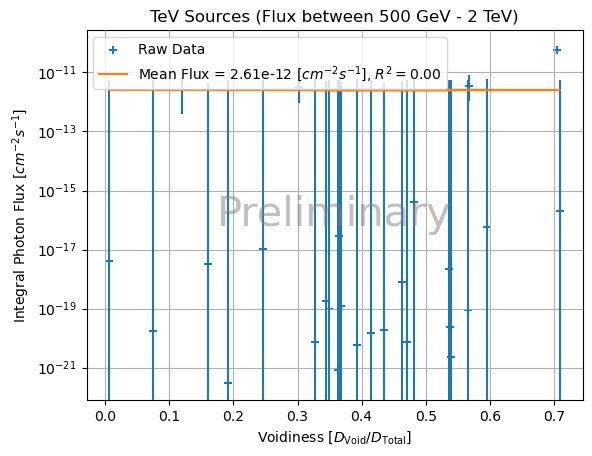

In [77]:
bands = ["10 - 20 GeV",
         "20 - 50 GeV",
         "50 - 150 GeV",
         "150 - 500 GeV",
         "500 GeV - 2 TeV"]
fn_bands = ["10_20",
         "20_50",
         "50_150",
         "150_500",
         "500_2_TeV"]

TEVchi2_log = np.zeros((5,1,3))
TEVchi2_nolog = np.zeros((5,1,3))

for i in range(5):
    temp_flux = faux_flux[i, :] # all fitting will be done to the averaged data points in between the uncertainties
    temp_voidis = np.array(voidis)
    plt.figure()
    plt.errorbar(temp_voidis, faux_flux[i, :], yerr=faux_unc[i,:], linestyle='')
    plt.scatter(temp_voidis, flux_bands[:, i], marker='+', label="Raw Data")
    plt.yscale('log') # matplotlib log is base 10 !!
    plt.grid()
    plt.title(f"TeV Sources (Flux between {bands[i]})")
    plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
    plt.ylabel("Integral Photon Flux [$cm^{-2} s^{-1}$]")
        # Line fit
    # Note. the true lin-lin (x-y) values of voidiness and flux are given to plt. 
    # but its plotted in lin-log space. we fit the curve to lin-log space
    # Then plot the lin-lin values by raising the fitted curve to np.exp

    avg = np.mean(temp_flux)
    avg_line = avg * np.ones_like(temp_voidis)
    # Plotted later so that it matches the other graph
    # plt.plot(np.array(voidis), 10**(avg_line), label=f"Mean Flux = {10**avg:.2e}")

    popt, pcov = curve_fit(linear_model, temp_voidis, temp_flux, sigma=faux_unc[i,:])
    # popt, pcov = curve_fit(linear_model, np.array(voidis), np.log(temp_flux), sigma=np.log(faux_unc[i,:]))
    slope, intercept = popt
    fit_line_w_err = linear_model(temp_voidis, slope, intercept)

    chi2_fit_nolog = np.sum(((temp_flux - (fit_line_w_err))**2)/(fit_line_w_err))/(len(temp_flux) - 1)

    p_fit = chi2.sf(chi2_fit_nolog, len(temp_flux) - 1)


    # chi2_fit_log = np.sum((np.log10(temp_flux) - (fit_line_w_err))**2/(fit_line_w_err))
    # chi2_fit_nolog = np.sum((temp_flux - np.exp(fit_line_w_err))**2/np.exp(fit_line_w_err))
    # chi2_fit_log = np.sum((np.log(temp_flux) - np.exp( fit_line_w_err))**2/np.exp(fit_line_w_err))

    # chi2, p = stats.chisquare(temp_flux, 10**fit_line_w_err)

    # Theres two ways to go about this. I could calcualte a chi-squared using the
    # lin-lin error
    # OR claculate a chi-squared for the log-lin error. 
    chi2_avg_nolog = np.sum(((temp_flux - (avg))**2)/(avg))/(len(temp_flux) - 1)
    p_avg = chi2.sf(chi2_avg_nolog, len(temp_flux) - 1)
    # chi2_avg_log = np.sum((np.log10(temp_flux) - (avg))**2)/(avg)

    # difflog = chi2_fit_log - chi2_avg_log
    diffnolog = chi2_fit_nolog - chi2_avg_nolog

    # TEVchi2_log[i, 0, :] = [chi2_fit_log, chi2_avg_log, difflog]
    TEVchi2_nolog[i, 0, :] = [chi2_fit_nolog, chi2_avg_nolog, diffnolog]

    r2_fit = r2_score(temp_flux, (fit_line_w_err))
    r2_avg = r2_score(temp_flux, avg_line)

     # using scipt to calcualte q-squared and its significant

    # chi2_fit_scipy, p_fit = chisquare(temp_flux, 10**fit_line_w_err, ddof=len(temp_flux)-1)
    chi2_avg_scipy, p_avg_scipy = chisquare(temp_flux, avg_line, ddof=len(temp_flux)-1)
    print(chi2_avg_scipy)


    # Ordering the data points to get 
    ordered_idx = np.argsort(temp_voidis)
    ord_voidis = temp_voidis[ordered_idx]
    ord_fit = fit_line_w_err[ordered_idx]

    #$R^2 =${r2_fit:.2f},
    # $\Delta\chi^2_{{no log}}=${diffnolog:.2e}
    # not plotting the fit line for AAS
    # plt.plot(ord_voidis, ord_fit, label=f'Fit Line, $R^2 =${r2_fit:.2f}, $\chi^2=$ {chi2_fit_nolog:.2e}, p = {p_fit:.2f}')

    # $R^2 =${r2_avg:.2f}
    #  $\chi^2 = {chi2_avg_nolog:0.2e}$, p = {p_avg:.2f}, $\chi^2_{{scipy}} =$ = {chi2_avg_scipy:.2e}
    plt.plot(np.array(voidis), (avg_line), label=f"Mean Flux = {avg:.2e} [$cm^{{-2}} s^{{-1}}$], $R^2 =${r2_avg:.2f}")

    plt.legend(loc='upper left')
    plt.text(0.5, 0.5, "Preliminary",  # Adjust the position as needed
                 fontsize=30, color='gray', alpha=0.5,
                 ha='center', va='center', transform=plt.gca().transAxes)

    dirs = "./output_plots/nsf_proposal/"
    fn = "Integral_Photon_Flux_between_" + fn_bands[i] + "_(TEV_Sources)_vs_Voidiness.PS"
    # plt.savefig(dirs + fn)
    # Needs preliminary

In [78]:
faux_flux[2, :]

array([1.23631716e-10, 2.43698490e-11, 1.28844461e-11, 9.20691134e-10,
       2.95167163e-11, 4.04549259e-11, 8.50469781e-12, 8.76083485e-11,
       9.01272590e-11, 1.76560873e-11, 3.13314912e-11, 3.97771855e-11,
       1.26333711e-11, 1.73836299e-11, 2.00665376e-11, 2.79860683e-11,
       1.69968859e-11, 1.30323749e-11, 1.42631202e-11, 3.49905907e-11,
       7.47468016e-12, 1.11463380e-11, 7.26470550e-11, 2.86226876e-11,
       4.88893249e-11, 6.42964230e-12, 1.59386462e-11])

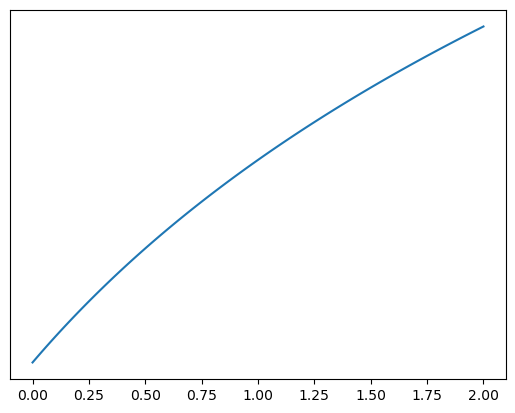

In [79]:
def exp(x):
    return 10**x

vals = np.linspace(-0, 2, 100)

plt.plot(vals, 2 * vals  + 3)
plt.yscale('log', base=np.exp(1))

In [80]:
vals

array([0.        , 0.02020202, 0.04040404, 0.06060606, 0.08080808,
       0.1010101 , 0.12121212, 0.14141414, 0.16161616, 0.18181818,
       0.2020202 , 0.22222222, 0.24242424, 0.26262626, 0.28282828,
       0.3030303 , 0.32323232, 0.34343434, 0.36363636, 0.38383838,
       0.4040404 , 0.42424242, 0.44444444, 0.46464646, 0.48484848,
       0.50505051, 0.52525253, 0.54545455, 0.56565657, 0.58585859,
       0.60606061, 0.62626263, 0.64646465, 0.66666667, 0.68686869,
       0.70707071, 0.72727273, 0.74747475, 0.76767677, 0.78787879,
       0.80808081, 0.82828283, 0.84848485, 0.86868687, 0.88888889,
       0.90909091, 0.92929293, 0.94949495, 0.96969697, 0.98989899,
       1.01010101, 1.03030303, 1.05050505, 1.07070707, 1.09090909,
       1.11111111, 1.13131313, 1.15151515, 1.17171717, 1.19191919,
       1.21212121, 1.23232323, 1.25252525, 1.27272727, 1.29292929,
       1.31313131, 1.33333333, 1.35353535, 1.37373737, 1.39393939,
       1.41414141, 1.43434343, 1.45454545, 1.47474747, 1.49494

In [81]:
vals

array([0.        , 0.02020202, 0.04040404, 0.06060606, 0.08080808,
       0.1010101 , 0.12121212, 0.14141414, 0.16161616, 0.18181818,
       0.2020202 , 0.22222222, 0.24242424, 0.26262626, 0.28282828,
       0.3030303 , 0.32323232, 0.34343434, 0.36363636, 0.38383838,
       0.4040404 , 0.42424242, 0.44444444, 0.46464646, 0.48484848,
       0.50505051, 0.52525253, 0.54545455, 0.56565657, 0.58585859,
       0.60606061, 0.62626263, 0.64646465, 0.66666667, 0.68686869,
       0.70707071, 0.72727273, 0.74747475, 0.76767677, 0.78787879,
       0.80808081, 0.82828283, 0.84848485, 0.86868687, 0.88888889,
       0.90909091, 0.92929293, 0.94949495, 0.96969697, 0.98989899,
       1.01010101, 1.03030303, 1.05050505, 1.07070707, 1.09090909,
       1.11111111, 1.13131313, 1.15151515, 1.17171717, 1.19191919,
       1.21212121, 1.23232323, 1.25252525, 1.27272727, 1.29292929,
       1.31313131, 1.33333333, 1.35353535, 1.37373737, 1.39393939,
       1.41414141, 1.43434343, 1.45454545, 1.47474747, 1.49494

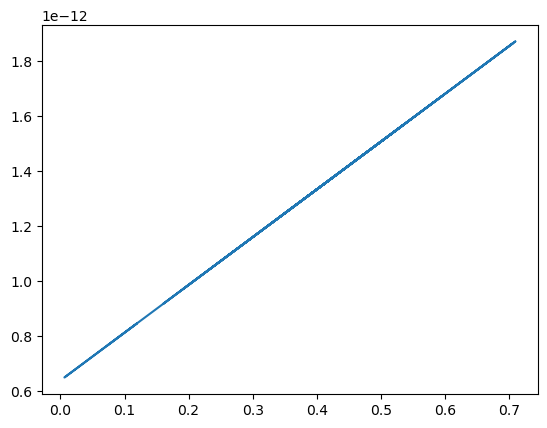

In [82]:
plt.plot(voidis, fit_line_w_err, label=f'Fit Line: y = {slope:.2e}x + {intercept:.2e}')
# plt.yscale('log')

In [83]:
# Line fit on Tevs Spectral vs Voidiniess curve

def line(x,m, b):
    return m * x + b

popt, pcov = curve_fit(line, voidis, SPEC_index, sigma=SPEC_uncert)

plt.plot(voidis, line(voidis, *popt))
plt.errorbar(voidis, SPEC_index, yerr=SPEC_uncert)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
voidis

# Statistical Analysis

### Distance Histograms

#### Prelim Histograms for Debugging

In [ ]:
# Defining some Useful base plotting parameters
xlabel = 'Distance Deg'
ylabel = 'Count'
base_title = 'Distances.'

##### Fermi Data

In [ ]:
vhe_seps = dist_w_skycoord(vhe_coords_gal) 
# verify_combo_count(vhe_seps, n=len(vhe_coords_gal)) # If its quiet we are good. 

##### Random Data

In [ ]:
if masked:
    mask = MASK_deg # apply 10 degree mask
else:
    mask = 0 # no mask
rand_coords_gal = generate_rand_Coords_static(len(vhe_coords_cel), mask = mask, seeded=False)
rand_coords_cel = rand_coords_gal.fk5 # book keeping

In [ ]:
rand_seps = dist_w_skycoord(rand_coords_gal)

In [ ]:
labels = ["FERMI", "Random Data"]

In [ ]:
plot_hist([vhe_seps, rand_seps],
          label=labels,
          xlabel = xlabel,
          ylabel = 'Percent',
          title = base_title + f' Masked: {masked}',
        #   bins = 3,
        # histtype='bar',
        # stacked=True,
          )

In [ ]:
plot_hist([vhe_coords_gal.l.value, rand_coords_gal.l.value],
          label=labels,
          title = f'Galactic Longitude (l) Distribution. Masked: {masked}',
          xlabel = 'Angle Deg',
          ylabel = 'Percent',
          bins=75)
plot_hist([vhe_coords_gal.b.value, rand_coords_gal.b.value],
          label = labels,
          title = f'Galactic Latitude (b) Distribution. Masked: {masked}',
          xlabel = 'Angle Deg',
          ylabel = 'Percent',
          bins=75)

In [ ]:
# generate_rand_l_and_b(1000) # quickly testing they are independen distributions

In [ ]:
# Fermi and Random plot in Celestial
ax = plt.axes(projection="geo aitoff")
ax.grid()
rand_coords_cel
ax.scatter(rand_coords_cel.ra.deg, rand_coords_cel.dec.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Random Points',
        )
ax.scatter(vhe_coords_cel.ra.deg, vhe_coords_cel.dec.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Fermi Data',
        )
plt.legend(loc="lower right")
plt.title(f"Coordinate Skymap, Celestial, Mask: {masked}")

In [ ]:
# Fermi and and random plot in galactic
ax = plt.axes(projection="geo aitoff")
ax.grid()
rand_coords_cel
ax.scatter(rand_coords_gal.spherical.lon.deg, rand_coords_gal.spherical.lat.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Random Points',
        )
ax.scatter(vhe_coords_gal.spherical.lon.deg, vhe_coords_gal.spherical.lat.deg,
           transform=ax.get_transform('world'),
           s=1,
           marker='o',
           label='Fermi Data',
        #    c=void_table['z'],
        #    alpha = 0.4
        )
plt.legend(loc="lower right")
plt.title(f"Coordinate Skymap, Galactic, Mask: {masked}")

In [ ]:
pls = generate_rand_Coords_static(len(vhe_coords_cel))

In [ ]:
len(vhe_coords_cel)

#### Little Bit to figure out average number of coordinates cut out. 

In [ ]:
# Little bit of code to figure out mean number of coordinates cut out by mask
# Then add them to total number of random coordinates generated


# if True:
#     n = 10000000
#     n_coords = np.zeros(n)
#     len_vhe = len(vhe_coords)
#     with Pool(12) as p:
#         n_coords = p.map(len_gen_coords, [len_vhe] * n)

#     mean_n_cut = len_vhe - np.mean(n_coords) # 211 from 10,000,000 samplings

#### Sampling and Analysis

In [ ]:
# 1000 samples block takes ~ 5 min
n_coords = len(vhe_coords_gal) # number of coordinates to produce
n_samples = 10
BATCH_COUNT = 1

file_name = f'./Random_Data/test_{BATCH_COUNT}.pickle'
for i in range(10):
    with Pool(12) as p:
        rand_seps = p.map(sample_and_measure, [n_coords]*n_samples) # Nested list
    
    if BATCH_COUNT % 10 ==0: # Multiple of 10
        BATCH_COUNT += 1
        file_name = f'test_{BATCH_COUNT}.pickle'

    # Save rand_seps into a CSV file, overwriting the file each time.
    with open(file_name, 'ab') as file:
        pickle.dump(rand_seps, file)
    

In [ ]:
with open(file_name, 'rb') as file:
    save_data = pickle.load(file)

Take mean,for a single bin.

In [ ]:
flattened_seps = list(chain.from_iterable(rand_seps)) # Chain is faster

In [ ]:
# df = pd.DataFrame(rand_seps) # 2 mins for a 50 x 544,446 table. maybe pandas is not the way to go. 
# # if this was a 1000 table. this would take significantly longer.

In [ ]:
n_bins = 180
bins = np.linspace(0,180, n_bins + 1)

In [ ]:
# bin_indices = np.digitize(rand_seps, bins) - 1 # To fix 0 indexing


In [ ]:
# bin_indices

In [ ]:
# print(bin_indices == 89)

In [ ]:
# test_bi = bin_indices[0]

In [ ]:
# pandas has methods for handling large data sets
# df = pd.DataFrame({"Seperations": flattened_seps, "Bin": bin_indices})

In [ ]:
# bin_statistics = df.groupby('Bin')['Seperations'].agg(['mean', 'std'])

In [ ]:

plot_hist([vhe_seps, flattened_seps],
          label=['FERMI', 'Random Data', '1 Sigma'],
          xlabel = xlabel,
          ylabel = 'Percent',
          title = base_title + f' Masked: {masked}',
        #   bins = 3,
        # histtype='bar',
        # stacked=True,
          )